# Time Series Analysis of the San Antonio Metro Area

Author: Melody Bass

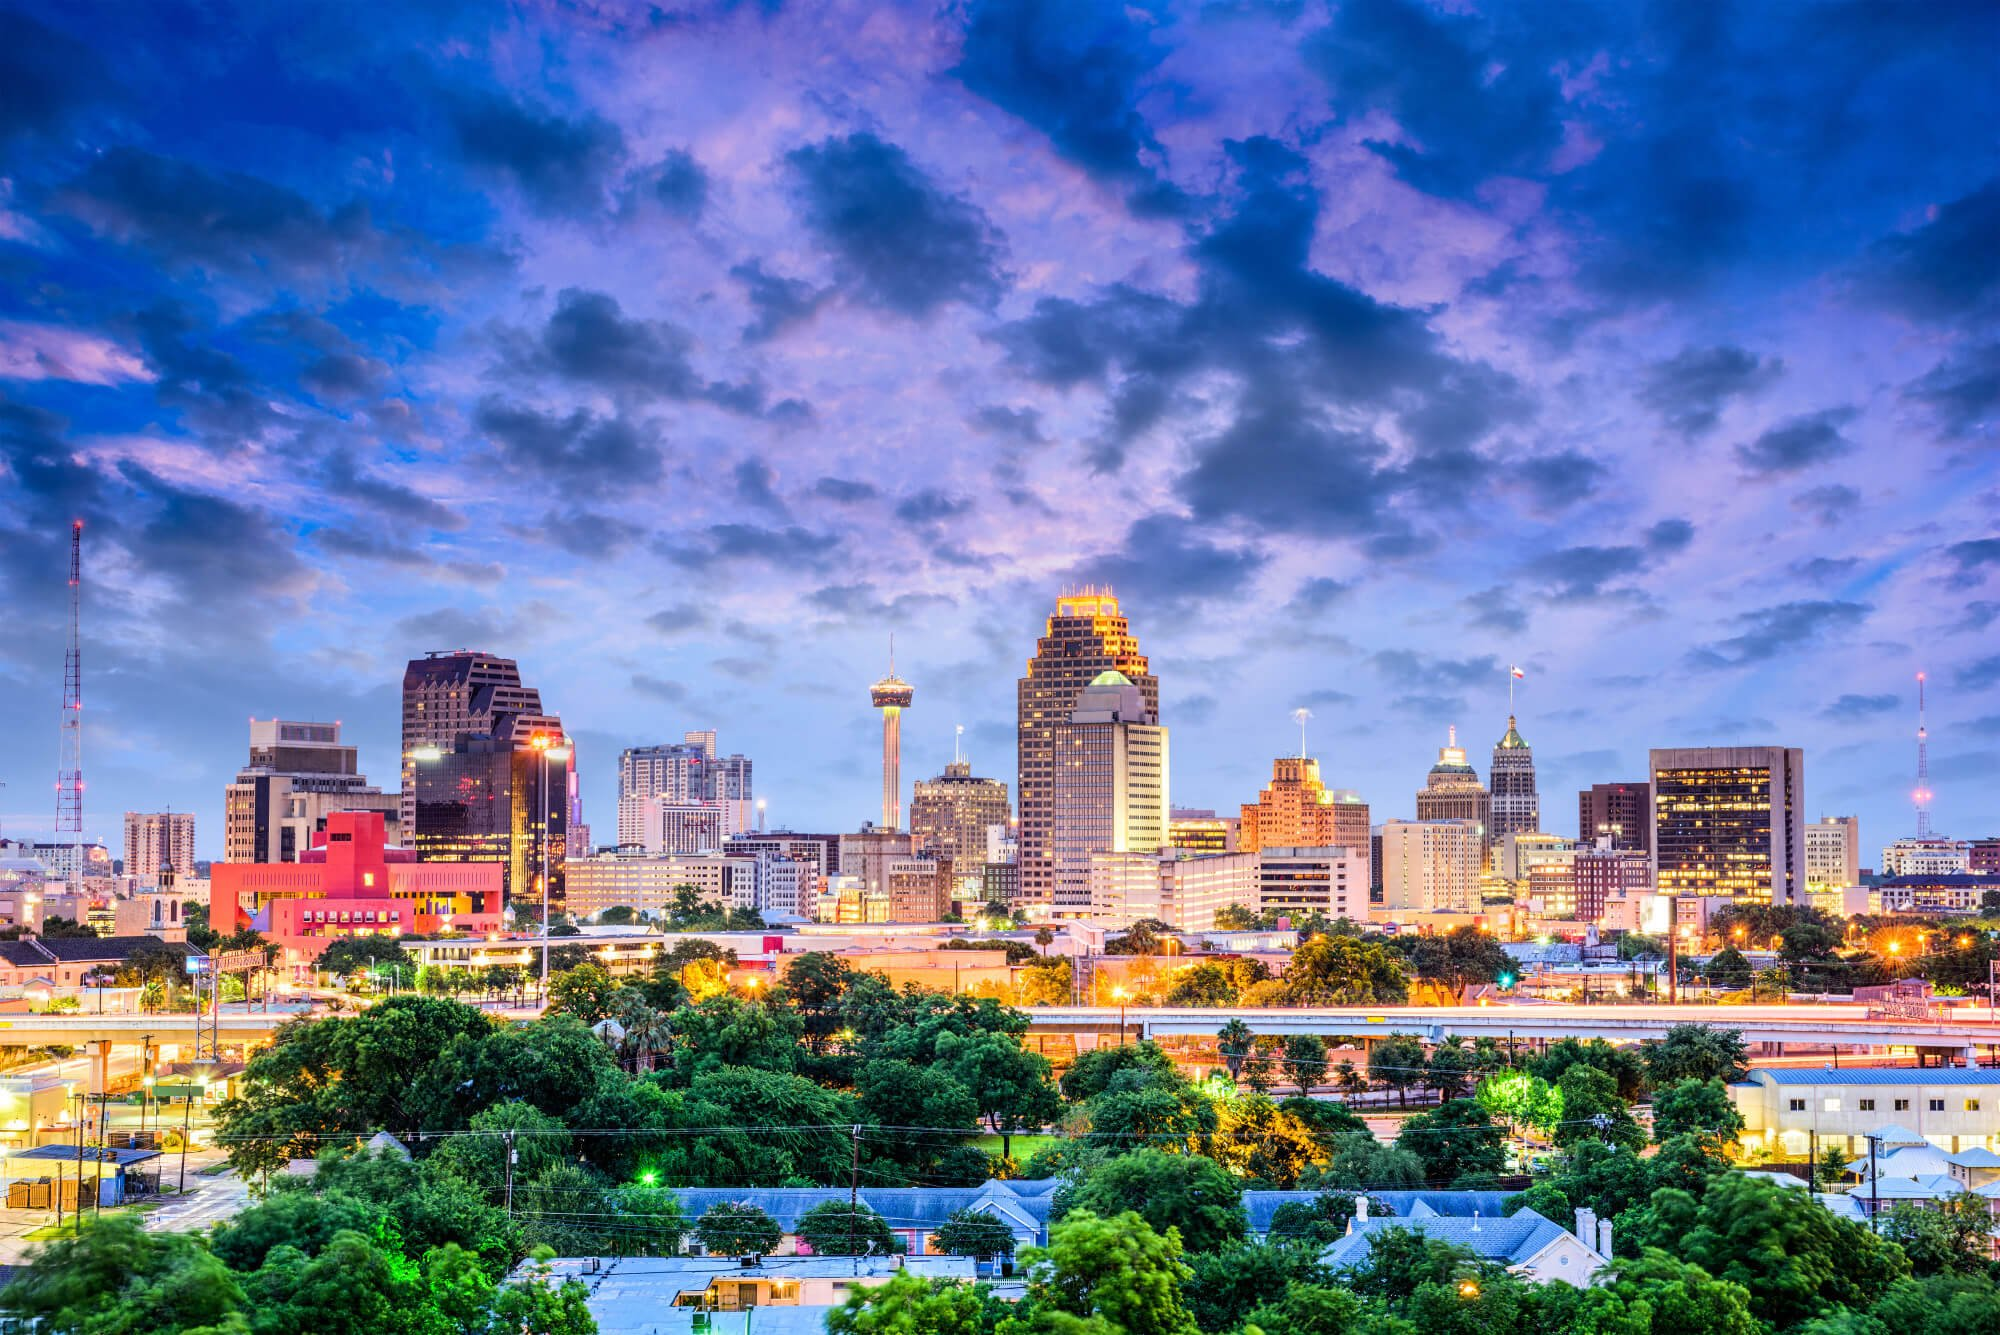

## Overview

San Antonio is the seventh-most populous city in the United States. According to Wikipedia, it was the fastest-growing city among those in the top ten, at roughly 2% growth per year. [[1]](https://en.wikipedia.org/wiki/San_Antonio) According to recent data from DCInno.com, San Antonio, over the last 4 years, was among the nation's fastest-growing cities for college-educated Millennials, and was tops in Texas. [[2]](https://www.forbes.com/sites/scottbeyer/2016/04/30/when-it-comes-to-millennial-appeal-san-antonio-is-creeping-on-austin/?sh=6d8c68727c57)

San Antonio has been one of the hottest real estate markets in the country for many years. It is one of the best places to visit and has one of the fastest-growing economies in the country, driven by sectors such as military, tourism, health care, and insurance. The U.S. Armed Forces have numerous facilities in and around San Antonio; including Fort Sam Houston, Lackland Air Force Base, Randolph Air Force Base, Kelly Air Force Base, Camp Bullis, and Camp Stanley. [[1]](https://en.wikipedia.org/wiki/San_Antonio)

The aim of this project is to provide a detailed analysis of the real estate market in the San Antonio metropolitan area using time series modeling and price forecasting.  Utilizing median monthly home sales prices contained in this [dataset](./data/zillow_2022.csv) prepared by Zillow, I will recommend the top 5 San Antonio metro zip codes to invest in to my client based on their specific needs.

## Business Problem

A new real estate investment firm has hired me to identify the top 5 neighborhoods in the SA metro area that would give them the highest return on investment upon selling in 3 - 5 years. 

They want to start with short term investments in one of the most lucrative real estate markets in the country.  The company is most interested in safe investments to ensure they will have cash flow to reinvest when the time comes.

## Data Understanding

The dataset used for this analysis contains median monthly housing sales prices for 265 zip codes over the period of January 2000 through June 2022 as reported by Zillow and can be found [here](./data/zillow_2022.csv).  This is the most up to date information that is available on [Zillow](https://www.zillow.com/research/data/).

Each row represents a unique zip code. Each record contains location info and median housing sales prices for each month.

There are 27280 rows and 277 variables:

* _RegionID_ - Unique index
* _RegionName_ - Unique Zip Code 
* _City_ - City in which the zip code is located
* _State_ - State in which the zip code is located
* _Metro_ - Metropolitan Area in which the zip code is located
* _CountyName_ - County in which the zip code is located
* _SizeRank_ - Numerical rank of size of zip code, ranked 1 through 34430
* _2000-01-31_ through _2022-06-30_ - median monthly housing sales prices from January 2000 through June 2022, that is 269 data points of monthly data for each zip code

Our business case is based solely in the San Antonio metro area, so I will filter the dataset down to only include the zip codes contained in the SA metro area.

In [267]:
# Basics
import pandas as pd
import numpy as np
import itertools

# Visualization
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import matplotlib.patches as mpatches
from matplotlib.pylab import rcParams
import time

# Modeling
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf, adfuller
from sklearn.linear_model import LassoLarsCV

# Warnings
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.filterwarnings('ignore')

In [268]:
# load in zillow home price data as df
df = pd.read_csv('data/zillow_2022.csv')
df = df.drop(columns = ['RegionType', 'StateName'], axis=1)
df.head()

RegionID  SizeRank  RegionName State          City  \
0         61639         0       10025    NY      New York   
1         84654         1       60657    IL       Chicago   
2         61637         2       10023    NY      New York   
3         91982         3       77494    TX          Katy   
4         84616         4       60614    IL       Chicago   
...         ...       ...         ...   ...           ...   
27275     66881     34430       21405    MD     Annapolis   
27276     78626     34430       47464    IN   Stinesville   
27277     98400     34430       95721    CA  Twin Bridges   
27278     95186     34430       86343    AZ    Crown King   
27279     95851     34430       89155    NV     Las Vegas   

                                     Metro           CountyName  2000-01-31  \
0              New York-Newark-Jersey City      New York County         NaN   
1                 Chicago-Naperville-Elgin          Cook County    378936.0   
2              New York-Newark-Jersey City      New York County         NaN   
3         Houston-The Woodlands-Sugar Land        Harris County    225068.0   
4                 Chicago-Naperville-Elgin          Cook County    497125.0   
...                                    ...                  ...         ...   
27275            Baltimore-Columbia-Towson  Anne Arundel County    485917.0   
27276                          Bloomington        Monroe County         NaN   
27277  Sacramento--Roseville--Arden-Arcade     El Dorado County    319100.0   
27278                             Prescott       Yavapai County    124025.0   
27279         Las Vegas-Henderson-Paradise         Clark County    214575.0   

       2000-02-29  2000-03-31  ...  2021-09-30  2021-10-31  2021-11-30  \
0             NaN         NaN  ...   1947464.0   1948627.0   1950816.0   
1        380056.0    382769.0  ...    703470.0    707917.0    713071.0   
2             NaN         NaN  ...   2864577.0   2866022.0   2864102.0   
3        225385.0    226110.0  ...    421730.0    429708.0    436807.0   
4        498166.0    500664.0  ...    942602.0    947407.0    954916.0   
...           ...         ...  ...         ...         ...         ...   
27275    486172.0    489058.0  ...   1183236.0   1191227.0   1206366.0   
27276         NaN         NaN  ...    180495.0    177581.0    177924.0   
27277    318480.0    319890.0  ...    439307.0    450076.0    452330.0   
27278    123076.0    121044.0  ...    213209.0    215313.0    214680.0   
27279    214567.0    215046.0  ...    454639.0    462775.0    470330.0   

       2021-12-31  2022-01-31  2022-02-28  2022-03-31  2022-04-30  2022-05-31  \
0       1948261.0   1963061.0   1991246.0   2032631.0   2061282.0   2073202.0   
1        717189.0    720446.0    721439.0    725713.0    728803.0    736222.0   
2       2855516.0   2862423.0   2865414.0   2895946.0   2922250.0   2971024.0   
3        442558.0    448665.0    458218.0    469926.0    483728.0    495207.0   
4        960563.0    966117.0    967202.0    972661.0    976754.0    986001.0   
...           ...         ...         ...         ...         ...         ...   
27275   1221326.0   1253345.0   1280884.0   1304040.0   1315300.0   1331683.0   
27276    180017.0    174619.0    165310.0    155058.0    153362.0    155640.0   
27277    451943.0    461050.0    461524.0    461921.0    451457.0    451336.0   
27278    215007.0    216014.0    218662.0    229218.0    239730.0    249718.0   
27279    476432.0    487058.0    498301.0    511370.0    521199.0    529338.0   

       2022-06-30  
0       2085824.0  
1        742394.0  
2       2996826.0  
3        502760.0  
4        994428.0  
...           ...  
27275   1346265.0  
27276    157954.0  
27277    437349.0  
27278    254153.0  
27279    534494.0  

[27280 rows x 277 columns]

In [269]:
# pd.set_option('display.max_rows', 1000)
df['Metro'].value_counts()

New York-Newark-Jersey City        894
Chicago-Naperville-Elgin           377
Los Angeles-Long Beach-Anaheim     357
Philadelphia-Camden-Wilmington     339
Washington-Arlington-Alexandria    309
                                  ... 
Winnemucca                           1
Ketchikan                            1
Clovis                               1
Portales                             1
Watertown                            1
Name: Metro, Length: 857, dtype: int64

In [270]:
#Dataframe containing only zips from San Antonio metro
sa_df = df[df['Metro']=='San Antonio-New Braunfels']
sa_df.head()

RegionID  SizeRank  RegionName State           City  \
21        92271        23       78130    TX  New Braunfels   
44        92341        47       78245    TX    San Antonio   
150       92336       153       78240    TX    San Antonio   
378       92345       382       78249    TX    San Antonio   
386       92350       390       78254    TX    San Antonio   
...         ...       ...         ...   ...            ...   
23818     92241     25756       78066    TX      Riomedina   
24516     92727     26739       78886    TX         Yancey   
24702     92194     27039       78004    TX       Bergheim   
24880     92215     27295       78027    TX       Kendalia   
26415     92198     29964       78008    TX    Campbellton   

                           Metro       CountyName  2000-01-31  2000-02-29  \
21     San Antonio-New Braunfels     Comal County         NaN         NaN   
44     San Antonio-New Braunfels     Bexar County    116692.0    116770.0   
150    San Antonio-New Braunfels     Bexar County    114140.0    114360.0   
378    San Antonio-New Braunfels     Bexar County    130419.0    130549.0   
386    San Antonio-New Braunfels     Bexar County    140116.0    140318.0   
...                          ...              ...         ...         ...   
23818  San Antonio-New Braunfels    Medina County         NaN         NaN   
24516  San Antonio-New Braunfels    Medina County         NaN         NaN   
24702  San Antonio-New Braunfels   Kendall County         NaN         NaN   
24880  San Antonio-New Braunfels   Kendall County         NaN         NaN   
26415  San Antonio-New Braunfels  Atascosa County         NaN         NaN   

       2000-03-31  ...  2021-09-30  2021-10-31  2021-11-30  2021-12-31  \
21            NaN  ...    309447.0    316516.0    324563.0    331119.0   
44       116760.0  ...    244895.0    248915.0    252611.0    257498.0   
150      114528.0  ...    253117.0    257176.0    260621.0    265487.0   
378      130699.0  ...    285095.0    289651.0    293690.0    298874.0   
386      140429.0  ...    291980.0    296552.0    300917.0    306526.0   
...           ...  ...         ...         ...         ...         ...   
23818         NaN  ...    365563.0    369156.0    371108.0    378559.0   
24516         NaN  ...    241105.0    242512.0    243132.0    242398.0   
24702         NaN  ...    532791.0    537466.0    545123.0    561733.0   
24880         NaN  ...    417418.0    422589.0    432760.0    447029.0   
26415         NaN  ...    151382.0    153475.0    154835.0    157712.0   

       2022-01-31  2022-02-28  2022-03-31  2022-04-30  2022-05-31  2022-06-30  
21       338337.0    344167.0    352261.0    360881.0    368831.0    374204.0  
44       262334.0    266894.0    272647.0    278366.0    283640.0    286831.0  
150      269931.0    274313.0    279550.0    285112.0    289780.0    292773.0  
378      304272.0    309388.0    315964.0    322271.0    327902.0    331461.0  
386      312036.0    317171.0    323982.0    330791.0    337059.0    340772.0  
...           ...         ...         ...         ...         ...         ...  
23818    386262.0    395213.0    398447.0    402198.0    404818.0    411987.0  
24516    241505.0    239318.0    236591.0    234061.0    234160.0    236838.0  
24702    578161.0    594376.0    599288.0    608080.0    620048.0    632704.0  
24880    462100.0    476262.0    482916.0    499934.0    517507.0    535968.0  
26415    161873.0    165845.0    167301.0    169326.0    171558.0    174902.0  

[105 rows x 277 columns]

In [271]:
sa_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105 entries, 21 to 26415
Columns: 277 entries, RegionID to 2022-06-30
dtypes: float64(270), int64(3), object(4)
memory usage: 228.0+ KB


In [272]:
sa_df.describe()

RegionID      SizeRank    RegionName     2000-01-31     2000-02-29  \
count    105.000000    105.000000    105.000000      69.000000      69.000000   
mean   92308.304762   8461.390476  78193.685714  130346.579710  130606.971014   
std       93.859564   7199.818934    156.834143   68273.344025   68513.528089   
min    92192.000000     23.000000  78002.000000   52991.000000   53036.000000   
25%    92255.000000   2025.000000  78108.000000   85073.000000   85130.000000   
50%    92307.000000   7824.000000  78211.000000  106068.000000  105880.000000   
75%    92336.000000  12186.000000  78240.000000  160421.000000  160555.000000   
max    92727.000000  29964.000000  78886.000000  427022.000000  429011.000000   

          2000-03-31     2000-04-30     2000-05-31     2000-06-30  \
count      69.000000      69.000000      69.000000      69.000000   
mean   130841.608696  131200.347826  130352.579710  129372.173913   
std     68645.817295   68970.006986   68488.408958   67993.126836   
min     53262.000000   53460.000000   53145.000000   52707.000000   
25%     85117.000000   85070.000000   84448.000000   83799.000000   
50%    106357.000000  106476.000000  105892.000000  104415.000000   
75%    160815.000000  161349.000000  160376.000000  159109.000000   
max    430687.000000  433365.000000  429486.000000  423804.000000   

          2000-07-31  ...     2021-09-30     2021-10-31     2021-11-30  \
count      69.000000  ...     105.000000     105.000000     105.000000   
mean   128274.115942  ...  299179.200000  303727.961905  308081.790476   
std     67319.078140  ...  125105.136229  127127.119538  129458.922458   
min     52316.000000  ...  130337.000000  132340.000000  133939.000000   
25%     83216.000000  ...  209230.000000  214001.000000  216781.000000   
50%    103917.000000  ...  253117.000000  257176.000000  260621.000000   
75%    157810.000000  ...  377877.000000  383584.000000  389152.000000   
max    418619.000000  ...  782875.000000  792882.000000  802164.000000   

          2021-12-31     2022-01-31     2022-02-28     2022-03-31  \
count     105.000000     105.000000     105.000000     105.000000   
mean   313948.133333  320226.352381  326126.866667  331758.419048   
std    132145.760604  135073.559608  137623.306022  140619.501583   
min    135065.000000  138026.000000  140476.000000  143550.000000   
25%    220297.000000  223694.000000  228774.000000  232163.000000   
50%    265487.000000  269931.000000  274975.000000  279394.000000   
75%    395785.000000  401241.000000  405732.000000  416233.000000   
max    815748.000000  829571.000000  842365.000000  860608.000000   

          2022-04-30     2022-05-31     2022-06-30  
count     105.000000     105.000000     105.000000  
mean   337743.838095  343256.361905  347860.333333  
std    144047.546938  147519.058141  150076.056156  
min    146151.000000  147977.000000  148461.000000  
25%    235234.000000  238297.000000  241416.000000  
50%    285015.000000  289780.000000  292773.000000  
75%    425492.000000  432636.000000  436334.000000  
max    878970.000000  897059.000000  907023.000000  

[8 rows x 273 columns]

In [273]:
sa_df.isna().sum()

RegionID      0
SizeRank      0
RegionName    0
State         0
City          0
             ..
2022-02-28    0
2022-03-31    0
2022-04-30    0
2022-05-31    0
2022-06-30    0
Length: 277, dtype: int64

Our filtered dataset contains a wide range of median home values, from a starting range of 53k to 427k for 105 zip codes in the SA metro area with several null values.  The null values are mostly contained in the early years of the data, but due to the massive growth of the area, there is data in the later years of the dataset.

## EDA

### Number of Zip Codes per City in SA Metro

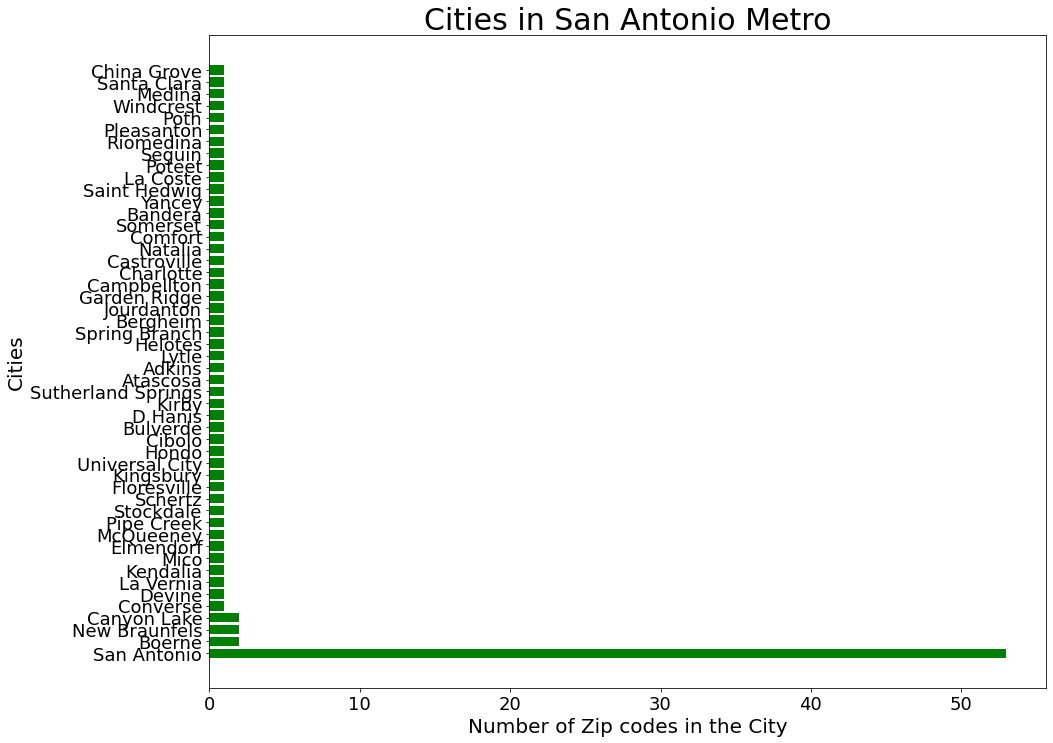

In [385]:
#Visualizing the value counts of zipcodes in each city in the San Antonio metro area

fig, ax = plt.subplots(figsize=(15,12))

y = [a for a in sa_df['City'].value_counts()]

x = [a for a in sa_df['City'].value_counts().keys()]

ax.barh(x,y,color='green')
ax.set_title('Cities in San Antonio Metro',fontsize=30)
ax.set_ylabel('Cities',fontsize=20)
ax.set_xlabel('Number of Zip codes in the City',fontsize=20)
fig.savefig('./images/zip_per_city.jpeg');

There are several small cities in the SA metro area that only have 1 zip code, while San Antonio itself contains 55 zip codes.

### Reshape from Wide to Long Format

The data needs to be melted from wide to long format in order to proceed with visualization and modeling.  Let's go ahead and do that now!

In [275]:
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], format = '%Y-%m')
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

In [380]:
# Get average of San Antonio metro zipcodes
satx_df_melted = melt_data(sa_df)
satx_df_melted.tail()

value
time                     
2022-02-28  326126.866667
2022-03-31  331758.419048
2022-04-30  337743.838095
2022-05-31  343256.361905
2022-06-30  347860.333333

In [277]:
# Get average of all US zipcodes
df_melted = melt_data(df)
df_melted.head()

value
time                     
2000-01-31  160670.656547
2000-02-29  161164.847325
2000-03-31  161690.402760
2000-04-30  162842.504295
2000-05-31  164204.550578

### San Antonio vs US Median Home Prices

In order to compare how San Antonio home prices stack up the the US Median home price, I created a time series for the average median prices of the San Antonio area and a time series for the average median price of the US.  Plotted together, we can see the differences.

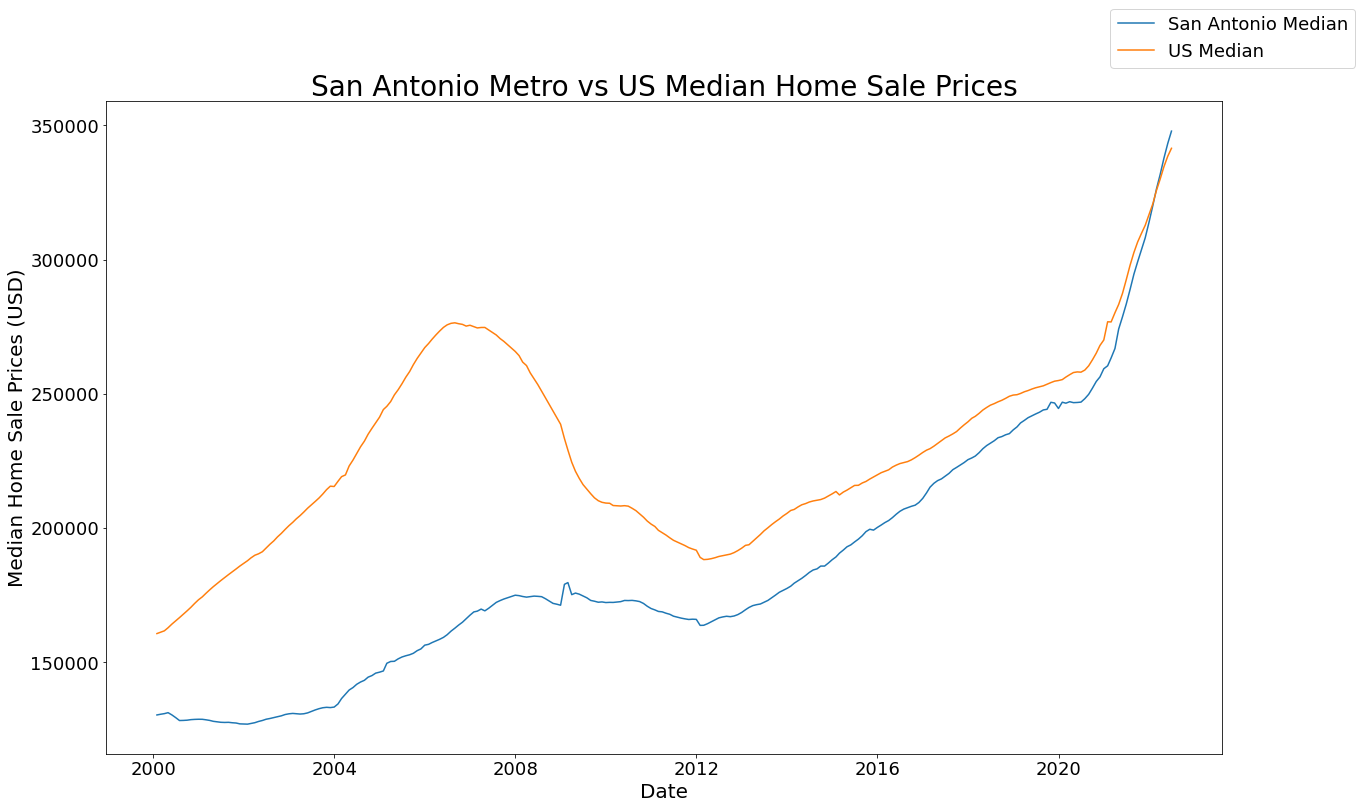

In [384]:
# Plot home value time series for all zip codes averaged

# Define figure
ax = plt.figure(figsize=(20,12))

# Plot
plt.plot(satx_df_melted, label = 'San Antonio Median')
plt.plot(df_melted, label = 'US Median')

# Title, x & y labels
plt.title('San Antonio Metro vs US Median Home Sale Prices', fontsize=28)
plt.ylabel('Median Home Sale Prices (USD)', fontsize=20)
plt.xlabel('Date', fontsize=20)
ax.legend()
plt.savefig('./images/sa_vs_us.jpeg')

plt.show()

The median home value in San Antonio metro used to be much lower than the national average, but has actually surpassed it this year!  This is due to the massive growth in the area and the low inventory of homes that are available for sale.  We can also see that the housing market in San Antonio was not as affected by the crash in 2008.  I will leave all of the data in the model to provide my client with a more conservative model to forecast housing prices.

Next, I will create another time series that will contain all the location info in long format.

In [279]:
#Create dataframe for new melted data
def melt_df(df):
    merged = []
    for zipcode in df.RegionName:
        melted = melt_data(df.loc[df['RegionName'] == zipcode])
        row = df.loc[df['RegionName'] == zipcode].iloc[:,:6]
        rows = pd.concat([row]*len(melted), ignore_index=True)
        merge = pd.concat([rows, melted.reset_index()], axis= 1)
        merged.append(merge)
    melted_df = pd.concat(merged)
    return melted_df

In [280]:
satx_df = melt_df(sa_df)
satx_df.head()

RegionID  SizeRank  RegionName State           City  \
0     92271        23       78130    TX  New Braunfels   
1     92271        23       78130    TX  New Braunfels   
2     92271        23       78130    TX  New Braunfels   
3     92271        23       78130    TX  New Braunfels   
4     92271        23       78130    TX  New Braunfels   

                       Metro       time     value  
0  San Antonio-New Braunfels 2007-01-31  167985.0  
1  San Antonio-New Braunfels 2007-02-28  168585.0  
2  San Antonio-New Braunfels 2007-03-31  169390.0  
3  San Antonio-New Braunfels 2007-04-30  170118.0  
4  San Antonio-New Braunfels 2007-05-31  170191.0

In [281]:
# Drop columns no longer needed
model_df = satx_df.drop(['RegionID','City','State','Metro','SizeRank'], axis ='columns').set_index('time')
model_df.head()

RegionName     value
time                            
2007-01-31       78130  167985.0
2007-02-28       78130  168585.0
2007-03-31       78130  169390.0
2007-04-30       78130  170118.0
2007-05-31       78130  170191.0

In [282]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24245 entries, 2007-01-31 to 2022-06-30
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   RegionName  24245 non-null  int64  
 1   value       24245 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 568.2 KB


### Average Housing Prices In San Antonio Metro Over Time

Let's take a look at the time series plotted for all 105 zip codes.  We will be able to see the overall trend, but will be very dense on the plot.

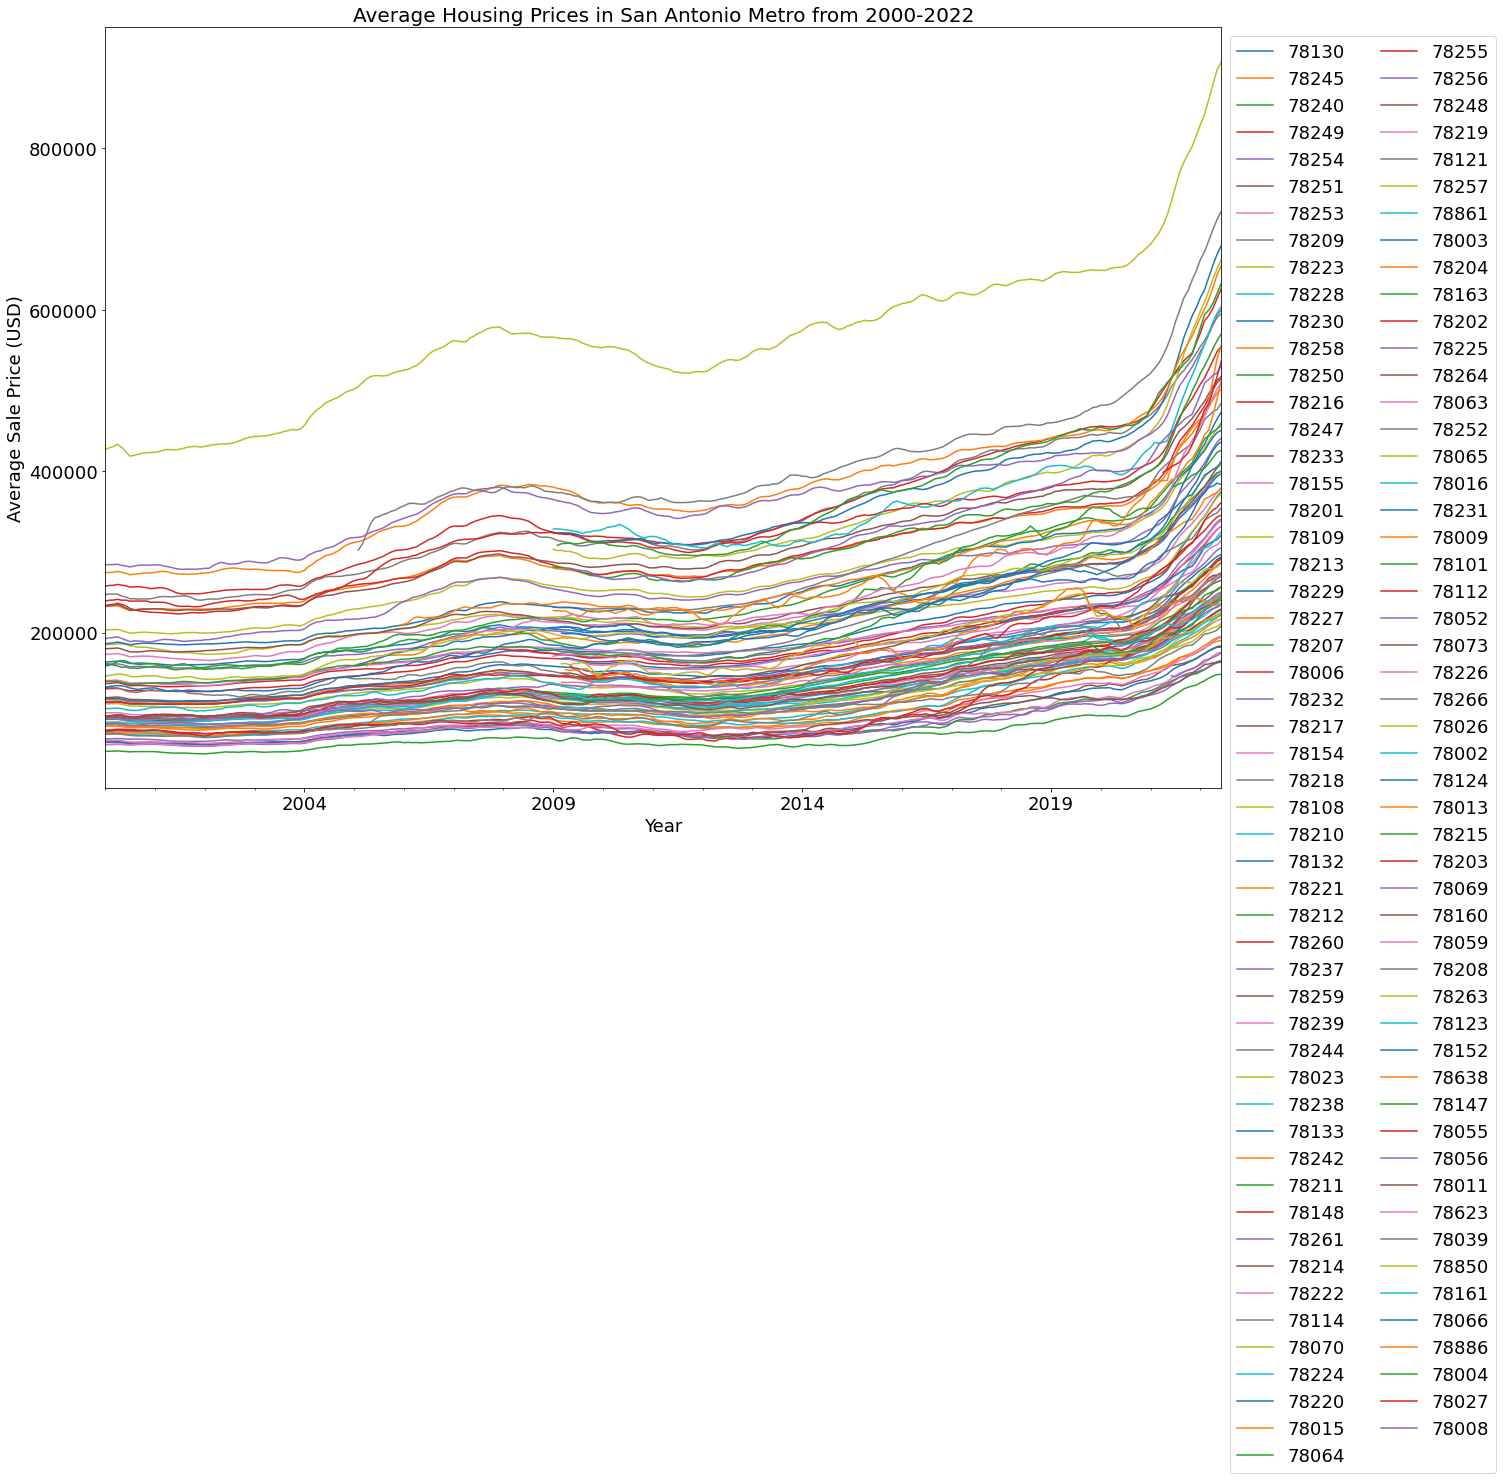

In [386]:
#plot the values grouped by zipcode
plt.figure(figsize=(20,14))
for zipcode in model_df.RegionName.unique():
    model_df.loc[model_df['RegionName'] == zipcode].value.plot(label=zipcode)
plt.legend(bbox_to_anchor=(1,1), loc='upper left', ncol=2)

plt.xlabel("Year", fontsize = 18)
plt.ylabel("Average Sale Price (USD)", fontsize=18)
plt.title('Average Housing Prices in San Antonio Metro from 2000-2022', fontsize = 20)
plt.savefig('./images/all_sa_prices.jpeg')
plt.show();


In [284]:
# Which zipcode is the one with the highest median value?
model_df.loc[model_df['value'] >= 800000]

RegionName     value
time                            
2021-11-30       78257  802164.0
2021-12-31       78257  815748.0
2022-01-31       78257  829571.0
2022-02-28       78257  842365.0
2022-03-31       78257  860608.0
2022-04-30       78257  878970.0
2022-05-31       78257  897059.0
2022-06-30       78257  907023.0

Much to my surprise, 78257 is outside of the main city loop.  These must be a development of custom luxury homes in Leon Springs.

### Zipcodes with Highest 5 Year ROI

In order to narrow down our focus before modeling, we will only keep 10 zip codes with highest ROI based on our last 5 years of historical data.  

In [285]:
# Create copy of df to calculate ROIs
roi_df = sa_df.copy()
roi_df.head()

RegionID  SizeRank  RegionName State           City  \
21      92271        23       78130    TX  New Braunfels   
44      92341        47       78245    TX    San Antonio   
150     92336       153       78240    TX    San Antonio   
378     92345       382       78249    TX    San Antonio   
386     92350       390       78254    TX    San Antonio   

                         Metro    CountyName  2000-01-31  2000-02-29  \
21   San Antonio-New Braunfels  Comal County         NaN         NaN   
44   San Antonio-New Braunfels  Bexar County    116692.0    116770.0   
150  San Antonio-New Braunfels  Bexar County    114140.0    114360.0   
378  San Antonio-New Braunfels  Bexar County    130419.0    130549.0   
386  San Antonio-New Braunfels  Bexar County    140116.0    140318.0   

     2000-03-31  ...  2021-09-30  2021-10-31  2021-11-30  2021-12-31  \
21          NaN  ...    309447.0    316516.0    324563.0    331119.0   
44     116760.0  ...    244895.0    248915.0    252611.0    257498.0   
150    114528.0  ...    253117.0    257176.0    260621.0    265487.0   
378    130699.0  ...    285095.0    289651.0    293690.0    298874.0   
386    140429.0  ...    291980.0    296552.0    300917.0    306526.0   

     2022-01-31  2022-02-28  2022-03-31  2022-04-30  2022-05-31  2022-06-30  
21     338337.0    344167.0    352261.0    360881.0    368831.0    374204.0  
44     262334.0    266894.0    272647.0    278366.0    283640.0    286831.0  
150    269931.0    274313.0    279550.0    285112.0    289780.0    292773.0  
378    304272.0    309388.0    315964.0    322271.0    327902.0    331461.0  
386    312036.0    317171.0    323982.0    330791.0    337059.0    340772.0  

[5 rows x 277 columns]

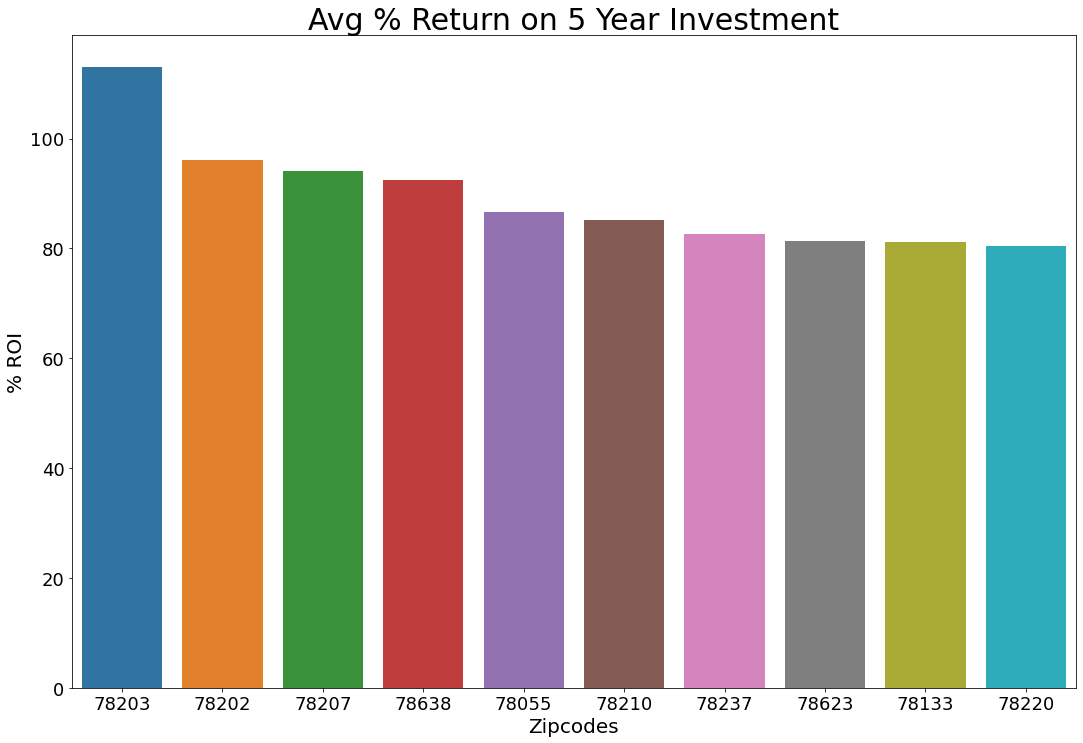

In [387]:
# Calculate 5 year ROI and keep top 10
roi_df['roi_5_year'] = ((roi_df['2022-06-30'] - roi_df['2017-06-30'])/(roi_df['2017-06-30'])*100)
sa_5_year_roi = roi_df.sort_values('roi_5_year',ascending=False).head(10)
sa_5_year_roi['RegionName'] = sa_5_year_roi['RegionName'].astype(str)

#Plot
fig,ax=plt.subplots(figsize=(18,12))
sns.barplot('RegionName', 'roi_5_year', data = sa_5_year_roi)

ax.set_ylabel('% ROI',fontsize='20')
ax.set_xlabel('Zipcodes',fontsize='20')
ax.set_title('Avg % Return on 5 Year Investment',fontsize='30')
plt.savefig('./images/roi_5_year.jpeg');

78203 contains the Arena District, which is the area surrounding the AT&T Center.  The other zip codes with highest ROI are spread all around the city in every direction. While most are around the downtown area, there are several suburbs like Canyon Lake and Medina that have taken the top ROI spots!

### Zip Codes with Highest 22 Year ROI

Out of curiosity, are the zip codes with the highest ROI over 22 years the same as the top 10 zip codes over the last 5 years?

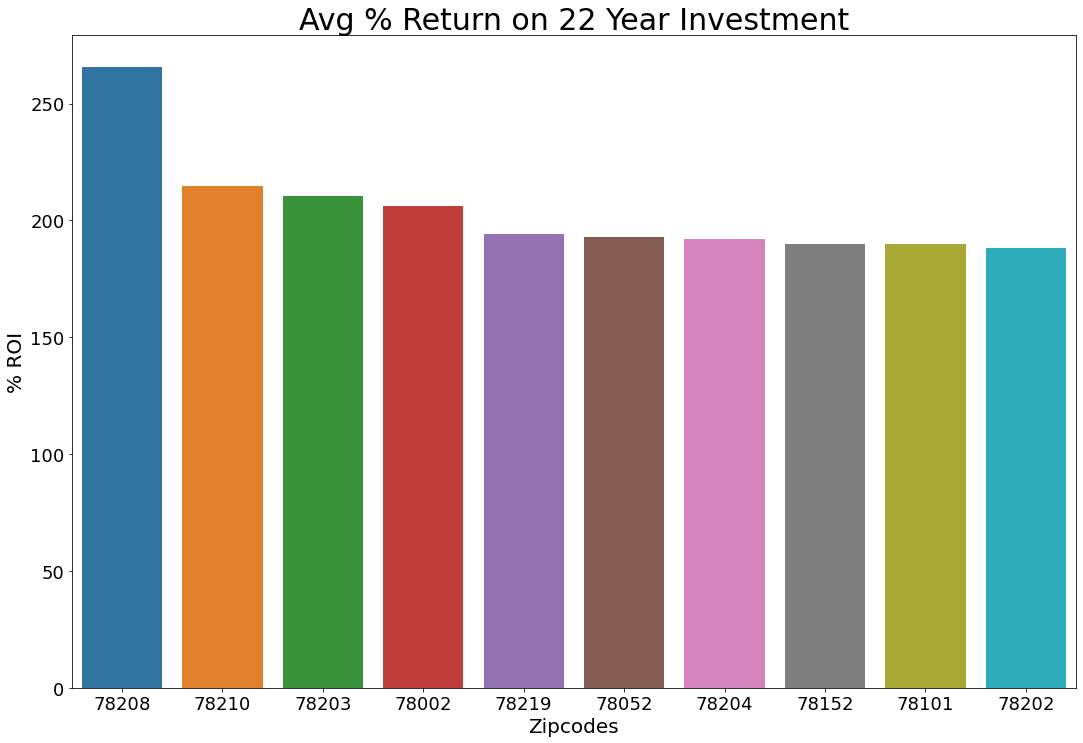

In [287]:
# Calculate 22 year ROI and keep top 10
roi_df['roi_22year'] = ((roi_df['2022-06-30'] - roi_df['2000-01-31'])/(roi_df['2000-01-31'])*100)
sa_22_year_roi = roi_df.sort_values('roi_22year',ascending=False).head(10)
sa_22_year_roi['RegionName'] = sa_22_year_roi['RegionName'].astype(str)

#Plot
fig,ax=plt.subplots(figsize=(18,12))
sns.barplot('RegionName', 'roi_22year', data = sa_22_year_roi)

ax.set_ylabel('% ROI',fontsize='20')
ax.set_xlabel('Zipcodes',fontsize='20')
ax.set_title('Avg % Return on 22 Year Investment',fontsize='30');

Only 3 zip codes that have the highest ROI on a 5 year investment are in the highest ROI over a 22 year investment.  This is once again due to new developments in the suburban areas, as well as gentrification of areas that were once undesirable.

### Discussion on EDA

There is a similar trend amongst all of our neighborhoods in the SA metro area.  There is also a very wide range of median housing values, where the more affluent neighborhoods have a a much higher value than others.

We can also cleary see the housing bubble and 2008 crash in the data.  Values increased rapidly starting in 2004 and took a dip through 2009, plateaued, and begin rising again in 2012.  All zip codes in the San Antonio metro were mildly affected by this crash in comparison to the rest of the US.  A number of reasons contributed to this crash outside of the typical housing market highs and lows, and while they are rare, they do occur and are unpredictable.  I am going to leave this data in for our model to create a more conservative forecast for my client.

According to the National Association of Realtors, the number of home sales increases significantly in the spring, with home sales increasing by 34% in February and March. Sales continue upward with the busiest home selling months being May through August, accounting for 40% of United States annual home sales volume. The slowest months are November through February. Prices of homes slightly increase during surge months when the demand in the market is higher. Therefore, selling homes during these peak times could prove to be advantageous for maximizing profits.[[4]](https://www.nar.realtor/blogs/economists-outlook/seasonality-in-the-housing-market) Knowing that there is going to be seasonality in our data, I will use SARIMAX for my time series model.  

## SARIMAX Modeling

### Create Time Series for Each Zip Code in Our Top 10

In [289]:
# Define function to create individual time series for each zipcode
def zipcode_ts(df, zipcode):
    '''
    Input:
        df : dataframe of Zillow housing data.
        zipcode : list of zip codes to iterate through.
    '''
    zipcode_df = df[df['RegionName'] == zipcode]
    zipcode_df = zipcode_df.drop(columns = 'RegionName', axis=1)
    return zipcode_df 

In [290]:
# Empty list
zip_df = []

#Zipcodes with highest 5 year ROI
zip_list = [78203,78202,78207,78638,78055,78210,78237,78623,78133,78220] 

# Return list of time series for each zipcode in our zip_list
for z in model_df['RegionName'].unique():
    for z in zip_list:
        training_data = zipcode_ts(model_df, z)
        zip_df.append(training_data)
    else:
        continue

In [2]:
# Sanity check
zip_df[0]

NameError: name 'zip_df' is not defined

Our zip_df now contains a list of 10 time series for each of our 10 zipcodes of interest.

### Seasonal Decomposition

We can also decompose our time series to look for trend and seasonality.  

Let's start by looking at our top ROI zip code - 78203 (Arena District), and 78133 (Canyon Lake), which has had huge ROI gains in the last 2 years compared to all data in the dataset.

In [292]:
def decomposition_plot(ts):
    decomposition = sm.tsa.seasonal_decompose(ts, model='additive')

    #Gather the trend, seasonality, and residuals
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    # Plot gathered statistics
    plt.figure(figsize=(12,8))
    plt.subplot(411)
    plt.plot(ts, label='Original', color='blue')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend', color='blue')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality', color='blue')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals', color='blue')
    plt.legend(loc='best')
    plt.tight_layout();
    return decomposition_plot

<function __main__.decomposition_plot(ts)>

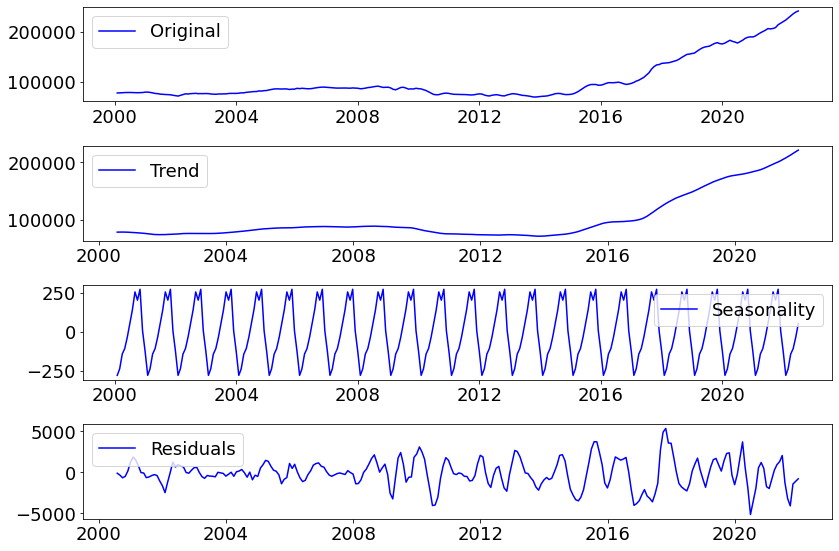

In [293]:
#Decomposition plot of the Arena District
decomposition_plot(zip_df[0])

<function __main__.decomposition_plot(ts)>

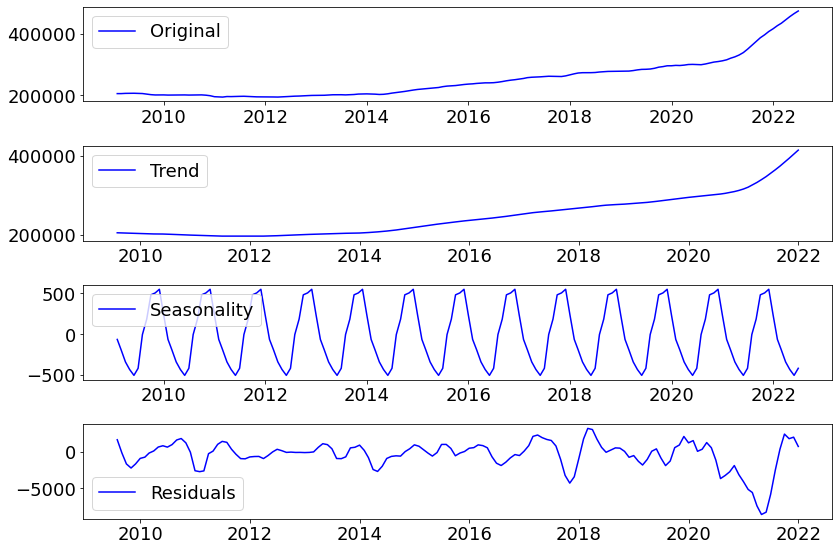

In [294]:
# #Decomposition plot of Canyon Lake
decomposition_plot(zip_df[8])

<function __main__.decomposition_plot(ts)>

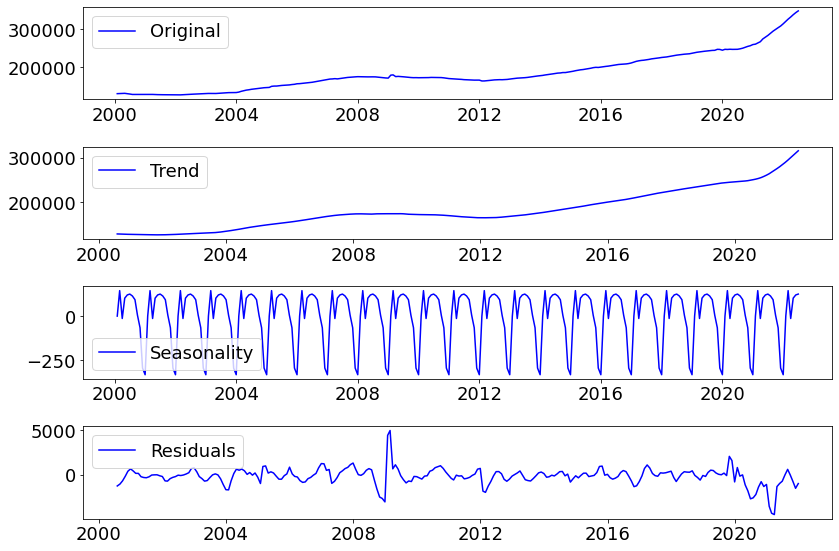

In [295]:
# Decomposition plot of the SA Metro area averaged
decomposition_plot(satx_df_melted)

We can clearly see the seasonality in the individual zip codes and the SA Median average.  There is also an overall upwards trend after the small dip after the housing bubble popped, with a steep increase over the last 2 years.

### Stationarity Check

In [296]:
def stationarity_check(TS):
    
    # Calculate rolling statistics
    roll_mean = TS.rolling(window=8, center=False).mean()
    roll_std = TS.rolling(window=8, center=False).std()
    
    # Perform the Dickey Fuller test
    dftest = adfuller(TS) 
    
    # Plot rolling statistics:
    fig = plt.figure(figsize=(12,6))
    orig = plt.plot(TS, color='blue',label='Original')
    mean = plt.plot(roll_mean, color='red', label='Rolling Mean')
    std = plt.plot(roll_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Print Dickey-Fuller test results
    print('Results of Dickey-Fuller Test: \n')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    return None

In [297]:
# Get decomposition for stationarity check
decomposition = sm.tsa.seasonal_decompose(satx_df_melted, model='additive')
residual = decomposition.resid
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)

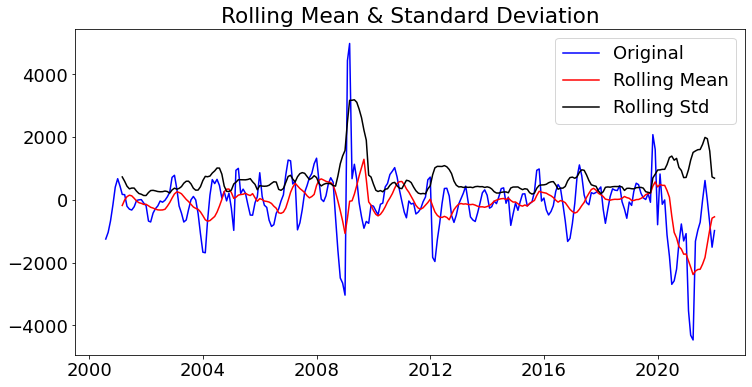

Results of Dickey-Fuller Test: 

Test Statistic                  -4.393976
p-value                          0.000304
#Lags Used                       6.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64


In [298]:
stationarity_check(ts_log_decompose)

The p-value is <0.05, which means we accept the null hypothesis that the residuals are stationary. We can move on to check our autocorrelation and partial autocorrelation plots.

### Autocorrelation and Partial Autocorrelation

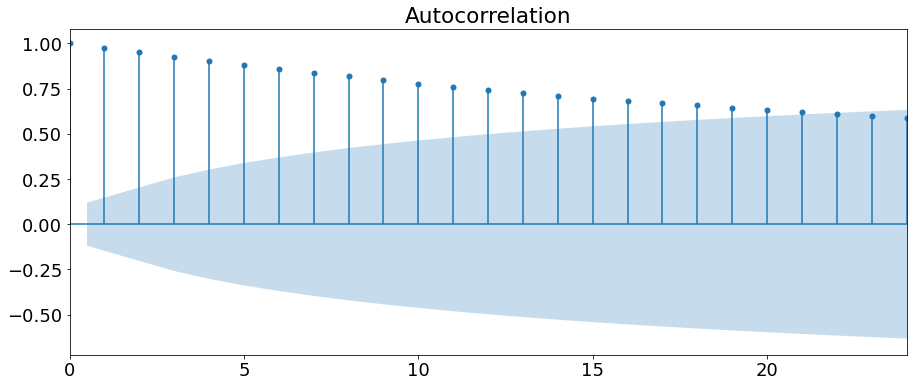

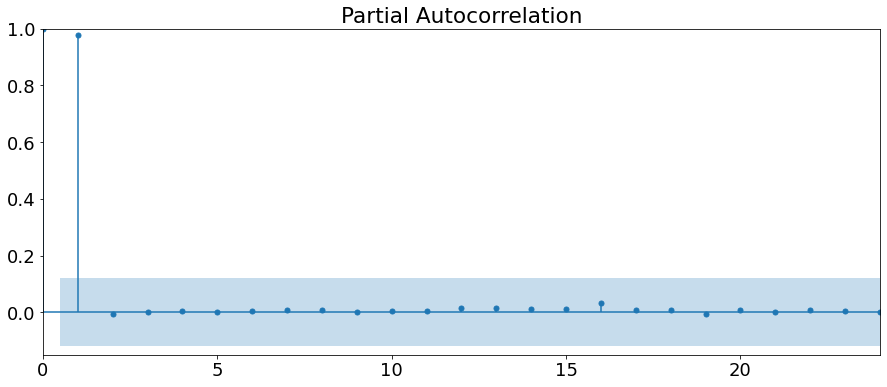

In [299]:
plot_acf(satx_df_melted); plt.xlim(0,24); plt.show()
plot_pacf(satx_df_melted); plt.xlim(0,24); plt.ylim(-0.15,1);plt.show()

There is a slow decline in our autocorrelation plot, while the partial autocorrelation drops off right away.  This means we should use an Autoregressive model for out data, but we are going to run gridsearch anyway to find best parameters.  We can try to plot again with a lag of 3, which would make sense for different seasons of the year.

<AxesSubplot:xlabel='time'>

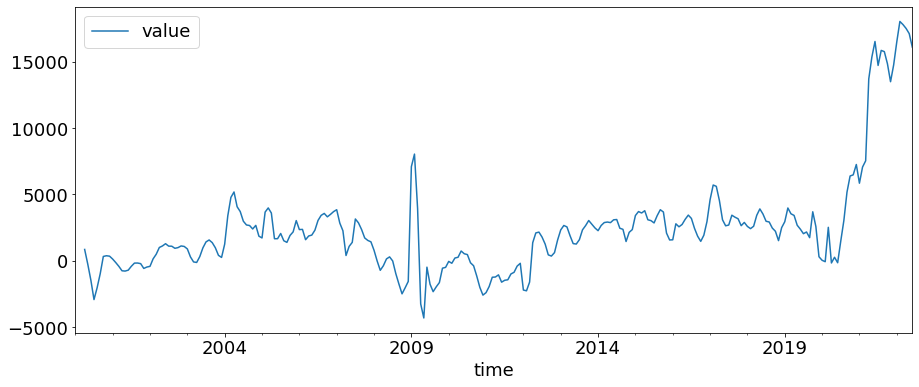

In [300]:
satx_df_melted.diff(periods=3).plot()

We can see some autocorrelation at a lag of 3.

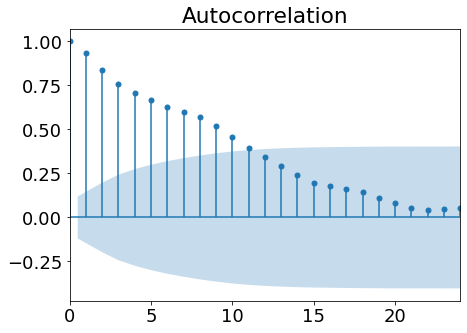

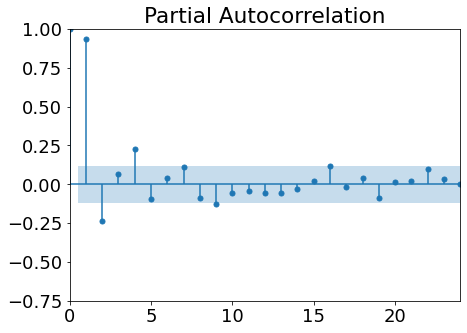

In [301]:
rcParams['figure.figsize']=7,5
plot_acf(satx_df_melted.diff(periods=3).bfill()); plt.xlim(0,24); plt.show()
plot_pacf(satx_df_melted.diff(periods=3).bfill()); plt.xlim(0,24); plt.ylim(-0.75,1);plt.show()

In [302]:
model_df

RegionName     value
time                            
2007-01-31       78130  167985.0
2007-02-28       78130  168585.0
2007-03-31       78130  169390.0
2007-04-30       78130  170118.0
2007-05-31       78130  170191.0
...                ...       ...
2022-02-28       78008  165845.0
2022-03-31       78008  167301.0
2022-04-30       78008  169326.0
2022-05-31       78008  171558.0
2022-06-30       78008  174902.0

[24245 rows x 2 columns]

### Gridsearch for SARIMAX Model

Next, I am going to conduct gridsearch to find optimal values for (p,d,q) and (P,D,Q,s) ranked by lowest AIC. This will provide  optimal paramets for each of my 10 zip codes of interest.

In [303]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [304]:
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []
for df, name in zip(zip_df, zip_list):
    for comb in pdq:
        for combs in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(df,
                                                order=comb,
                                                seasonal_order=combs,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                output = mod.fit()
                ans.append([name, comb, combs, output.aic])
                print('Result for {}'.format(name) + ' ARIMA {} x {}12 : AIC Calculated = {}'.format(comb, combs, output.aic))
            except:
                continue


Result for 78203 ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 7019.4166327271905
Result for 78203 ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 84009.30465452891
Result for 78203 ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5622.870386243331
Result for 78203 ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 5371.74710460903
Result for 78203 ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 5500.263984338111
Result for 78203 ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5481.179697261492
Result for 78203 ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 5238.3061736622185
Result for 78203 ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 6461.6577264304215
Result for 78203 ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 6799.994138687387
Result for 78203 ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 77739.27073484797
Result for 78203 ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5432.82112993742
Result for 78203 ARIMA (0, 0, 1

Result for 78202 ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4154.53727907722
Result for 78202 ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4097.005744923092
Result for 78202 ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 4564.563533532465
Result for 78202 ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4438.40851576591
Result for 78202 ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4436.6363802509
Result for 78202 ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4245.868922541618
Result for 78202 ARIMA (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4345.084216453923
Result for 78202 ARIMA (1, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4347.062268209052
Result for 78202 ARIMA (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4185.124517193524
Result for 78202 ARIMA (1, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4185.495344407687
Result for 78202 ARIMA (1, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4453.464232831721
Result for 78202 ARIMA (1, 0, 1) x (

Result for 78207 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 3833.302484553683
Result for 78207 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 3988.625756285858
Result for 78207 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 3976.044262741818
Result for 78207 ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 3862.453080802109
Result for 78207 ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 3841.0678733607697
Result for 78638 ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 4510.058607699948
Result for 78638 ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 615067.2815090527
Result for 78638 ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 3559.937922130389
Result for 78638 ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 3278.3073225835337
Result for 78638 ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 3507.2930828416506
Result for 78638 ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 3483.787780691735
Result for 78638 ARIMA (0, 0,

Result for 78055 ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 2578.65899161212
Result for 78055 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 2349.351868957855
Result for 78055 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 2625.2095625334414
Result for 78055 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 2557.09957324479
Result for 78055 ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 2390.3877556173065
Result for 78055 ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 2351.12538771644
Result for 78055 ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 2850.008389067403
Result for 78055 ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 2848.8884104965546
Result for 78055 ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 2634.7867612974796
Result for 78055 ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 2421.9684380254375
Result for 78055 ARIMA (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 2600.3300618919266
Result for 78055 ARIMA (1, 0,

Result for 78210 ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 3885.323824875931
Result for 78210 ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4192.947756916341
Result for 78210 ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4017.504904330584
Result for 78210 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4156.882626867273
Result for 78210 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 3885.3076267837887
Result for 78210 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4032.3470909961643
Result for 78210 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4019.6242920848945
Result for 78210 ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 3885.4789975763433
Result for 78210 ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 3868.5875649569753
Result for 78237 ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 6892.294214606187
Result for 78237 ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 6425.230611533589
Result for 78237 ARIMA (0, 

Result for 78623 ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 3004.4160513458046
Result for 78623 ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 2989.7644150054357
Result for 78623 ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 3361.8614708538225
Result for 78623 ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 3118.2245559424055
Result for 78623 ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 3115.004365529428
Result for 78623 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 2881.075242079416
Result for 78623 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 3200.572268145157
Result for 78623 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 3106.0318948479235
Result for 78623 ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 2923.745054906597
Result for 78623 ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 2887.9108921502366
Result for 78623 ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 3440.3633651059818
Result for 78623 ARIMA (1

Result for 78133 ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 2471.5544258626537
Result for 78133 ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 2311.7964050777464
Result for 78133 ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 2325.697353906402
Result for 78133 ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 2654.370877660519
Result for 78133 ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 2457.3777906953846
Result for 78133 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 2565.2397196847046
Result for 78133 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 2342.369640823589
Result for 78133 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 2472.2295101467107
Result for 78133 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 2454.6886213605767
Result for 78133 ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 2324.651436871336
Result for 78133 ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 2308.1136220100198
Result for 78220 ARIMA (0

In [305]:
# Find the parameters with minimal AIC value
ans_df = pd.DataFrame(ans, columns=['name', 'pdq', 'pdqs', 'aic'])
ans_df

name        pdq           pdqs           aic
0    78203  (0, 0, 0)  (0, 0, 0, 12)   7019.416633
1    78203  (0, 0, 0)  (0, 0, 1, 12)  84009.304655
2    78203  (0, 0, 0)  (0, 1, 0, 12)   5622.870386
3    78203  (0, 0, 0)  (0, 1, 1, 12)   5371.747105
4    78203  (0, 0, 0)  (1, 0, 0, 12)   5500.263984
..     ...        ...            ...           ...
635  78220  (1, 1, 1)  (0, 1, 1, 12)   3807.534751
636  78220  (1, 1, 1)  (1, 0, 0, 12)   3942.412763
637  78220  (1, 1, 1)  (1, 0, 1, 12)   3929.565653
638  78220  (1, 1, 1)  (1, 1, 0, 12)   3830.610297
639  78220  (1, 1, 1)  (1, 1, 1, 12)   3812.442178

[640 rows x 4 columns]

In [306]:
#Return the best set of parameters based on AIC
best_para = ans_df.loc[ans_df.groupby("name")["aic"].idxmin()]
best_para

name        pdq           pdqs          aic
319  78055  (1, 1, 1)  (1, 1, 1, 12)  2318.584674
575  78133  (1, 1, 1)  (1, 1, 1, 12)  2308.113622
123  78202  (1, 1, 1)  (0, 1, 1, 12)  4068.244419
63   78203  (1, 1, 1)  (1, 1, 1, 12)  4144.531317
187  78207  (1, 1, 1)  (0, 1, 1, 12)  3833.302485
383  78210  (1, 1, 1)  (1, 1, 1, 12)  3868.587565
635  78220  (1, 1, 1)  (0, 1, 1, 12)  3807.534751
443  78237  (1, 1, 1)  (0, 1, 1, 12)  3843.766288
511  78623  (1, 1, 1)  (1, 1, 1, 12)  2765.827273
255  78638  (1, 1, 1)  (1, 1, 1, 12)  2641.330470

### Best Parameters SARIMAX Model

Now that we have our optimal parameters for each zip code from our gridsearch, we will use the to build a sarimax model for each zip code.  Following are 3 functions we will use to build, evaluate and test each model, and forecast predictions for each of our top 10 zip codes.

In [307]:
# Define function to build SARIMAX model, print summary and output diagnostic plots
def sarimax(ts, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)):
    '''
    Input: 
    ts : Time series data.
    order : (p, d, q) values for ARIMA. Default = (1, 1, 1)
    seasonal_order : Seasonal (P, D, Q, s) values for SARIMA.
        Default = (1, 1, 1, 12).
        
    Output:
    Prints model output summary.
    Plots model diagnostics.
    
    Returns: Model output.
    '''
    
    # Sarimax model
    SARIMAX = sm.tsa.statespace.SARIMAX(ts, 
                                        order=order, 
                                        seasonal_order=seasonal_order, 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)
                                            
    # Fit the model and print results
    output = SARIMAX.fit()
    
    # Print output summary
    print(output.summary().tables[1])
    output.plot_diagnostics(figsize=(15,18));
    
    return output

In [308]:
def ose_forecast(ts, output, neighborhood =''):
    '''
    Plot forecast with real and predicted data.
    
    Input:
        ts : Time series.
        output : SARIMAX model output. 
        neighborhood : Name of city for plot title. 
        
    Output:
        Prints RMSE.
        Plots real vs. model predicted plot.
    '''

    # Get predictions starting from 2019-06-30 and calculate confidence intervals
    
    pred = output.get_prediction(start=pd.to_datetime('2019-06-30'), dynamic=False)
        
    # Get the real and predicted values
    ts_forecasted = pred.predicted_mean
    ts_truth = ts['2019-06-30':].value
    
    # Calc RMSE
    mse = mean_squared_error(ts_truth, ts_forecasted)
    rmse = np.sqrt(mse)

    # Print RMSE
    print('The RMSE of our forecasts is {}'.format(round(rmse, 2)))

    # Confidence Intervals
    pred_conf = pred.conf_int()

    ### Plot real vs predicted w/ confidence intervals ###

    rcParams['figure.figsize'] = 15, 6

    # Plot observed values
    ax = ts['2017-06-30':].plot(label='observed')

    # Plot predicted values
    
    ts_forecasted.plot(ax=ax, label='one-step ahead forecast', alpha=0.5)

    # Plot the range for confidence intervals
    ax.fill_between(pred_conf.index,
                    pred_conf.iloc[:, 0],
                    pred_conf.iloc[:, 1], color='g', alpha=.3)
        
    # Title
    ax.set_title(neighborhood)

    # Set axes labels
    ax.set_xlabel('Date')
    ax.set_ylabel('Median Home Value (USD)')
    plt.legend()

    return plt.show()

In [309]:
# Forecast 5 year predictions - Home Sale Values #

def dynamic_forecast(ts, model_output, years=5, neighborhood='', save_fig=False):
    '''
    Plots dynamic forecast for specified time into the future.
    
    Inputs: 
        ts : Time series data.
        model_output : Output results from our model.
        years : n-years to forcast into the future.
        neighborhood: Name of neighborhood for plots
            
    Outputs:
        Prints : Time series plot with one step ahead forecast.
        Returns : Dictionary of predictions.
    
    '''
    
    # Calcualte steps
    steps = years*12
    
    # Get forecast and confidence interval for steps ahead in future
    future = model_output.get_forecast(steps=steps, dynamic=True, full_results=True)
    future_conf = future.conf_int()
    
    ### Plot forecast ###
    
    # Observed
    ax = ts.plot(label='Observed', figsize=(12, 6))
    # Predicted
    future.predicted_mean.plot(ax=ax, label='dynamic forecast', alpha=0.9)

    # Confidence Intervals
    ax.fill_between(future_conf.index,
                    future_conf.iloc[:, 0],
                    future_conf.iloc[:, 1], color='k', alpha=.25)
    
    # Title
    ax.set_title(f"5-Year Forecast for {neighborhood}")
    
    # x & y-labels
    ax.set_xlabel('Date')
    ax.set_ylabel('Median Home Sale Value (USD)')
    
    # Legend
    ax.legend()
    
    if save_fig:
        plt.savefig(f'./images/dynamic_forecast_{neighborhood}.jpeg')
    
    # Print plot
    plt.show()

    # Forecast prediction for n-years into the future
    forecast = future.predicted_mean[-1]
    maximum = future_conf.iloc[-1,1]
    minimum = future_conf.iloc[-1,0]
    
    # Create dictionary of predictions
    predictions = {}
    predictions['forecast'] = forecast.round()
    predictions['minimum'] = minimum.round()
    predictions['maximum'] = maximum.round()
    
    return predictions

#### Arena District

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6052      0.063      9.657      0.000       0.482       0.728
ma.L1          0.0708      0.099      0.715      0.475      -0.123       0.265
ma.S.L12      -0.4880      0.025    -19.377      0.000      -0.537      -0.439
sigma2      1.354e+06   7.35e+04     18.427      0.000    1.21e+06     1.5e+06


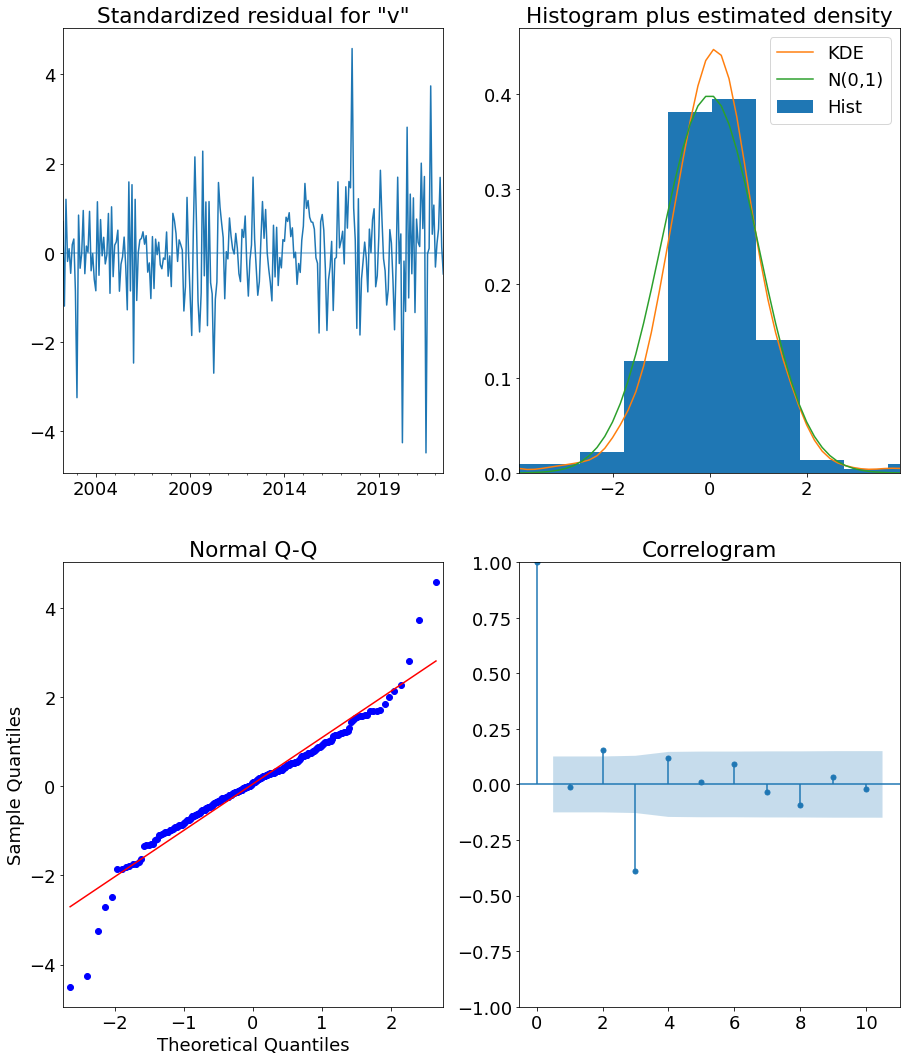

In [310]:
arena_district = zip_df[0]
output_arena_district = sarimax(arena_district, order=(1, 1, 1), seasonal_order=(0, 1, 1, 12))

The residuals look normally distributed, even though there are some heavy outliers presence in the tails of the Q-Q plot. We are likely going to see this in several of our following models.  This is due to the model being "confused" over the dip after the housing bubble, and the huge increases that have taken place in this area over the last few years.
We can see negative correlation in the correlogram at a month 3.  This makes sense knowing that we have seasonality in our data.  The ma.L1 has a p-value that is >0.05, and we will likely see this in all of our following zipcodes.  I am going to leave the model as is since I ran gridsearch to find optimal parameters.

The RMSE of our forecasts is 1816.45


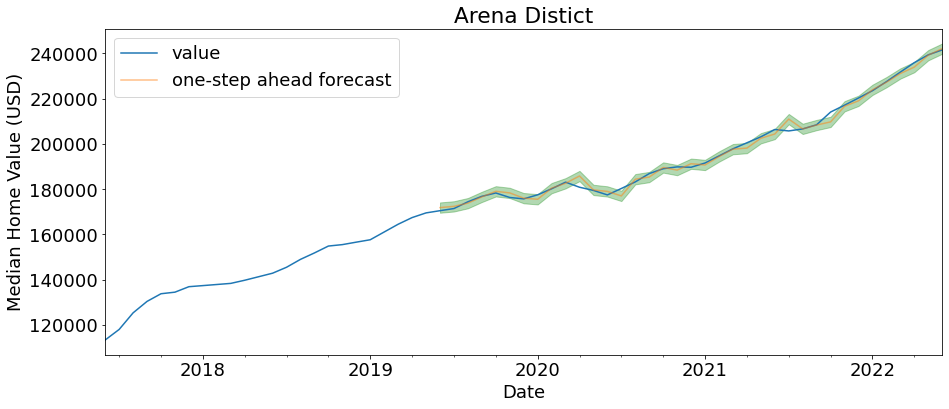

In [311]:
ose_forecast(arena_district, output_arena_district, neighborhood='Arena Distict')

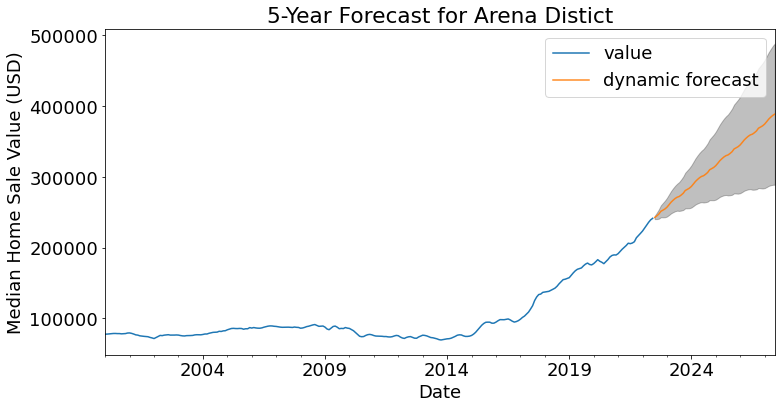

{'forecast': 388893.0, 'minimum': 289050.0, 'maximum': 488735.0}

In [389]:
dynamic_forecast(arena_district, output_arena_district, neighborhood='Arena Distict', years=5, save_fig=True)

The RMSE of our one step ahead forecast for the Arena District look great at $1,816! The confidence interval is small and the ROI of our minimum bounds are higher than the current value, which guarantees a positive ROI.  

#### Dignowity Hill

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4494      0.109      4.136      0.000       0.236       0.662
ma.L1          0.1275      0.130      0.981      0.326      -0.127       0.382
ar.S.L12      -0.3287      0.071     -4.651      0.000      -0.467      -0.190
ma.S.L12      -0.1885      0.049     -3.876      0.000      -0.284      -0.093
sigma2      1.045e+06    7.6e+04     13.747      0.000    8.96e+05    1.19e+06


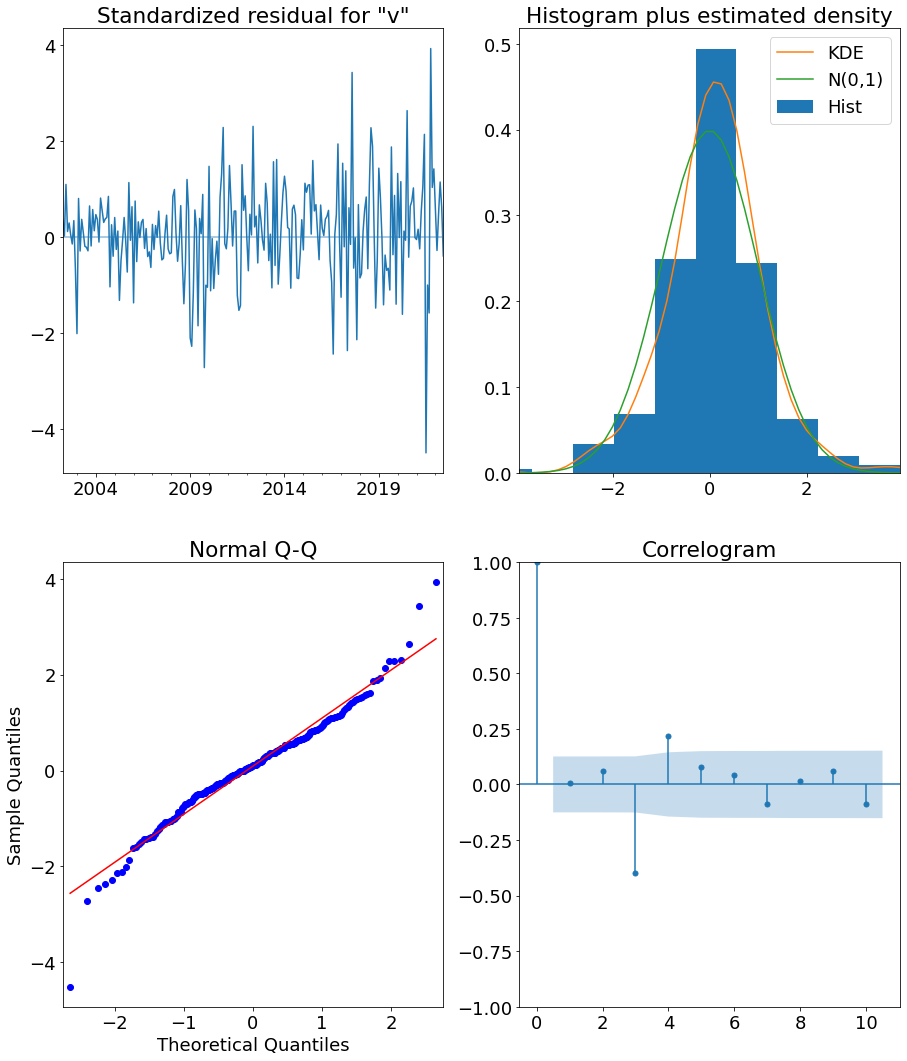

In [313]:
dig_hill = zip_df[1]
output_dig_hill = sarimax(dig_hill, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))

The RMSE of our forecasts is 1446.54


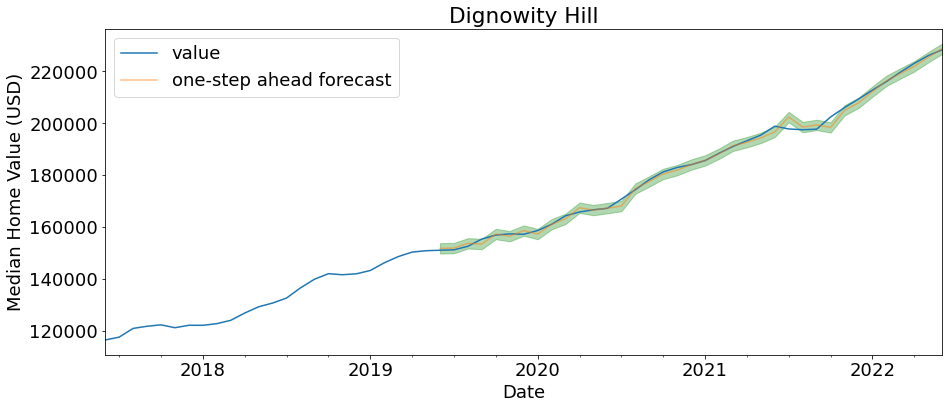

In [314]:
ose_forecast(dig_hill, output_dig_hill, neighborhood='Dignowity Hill')

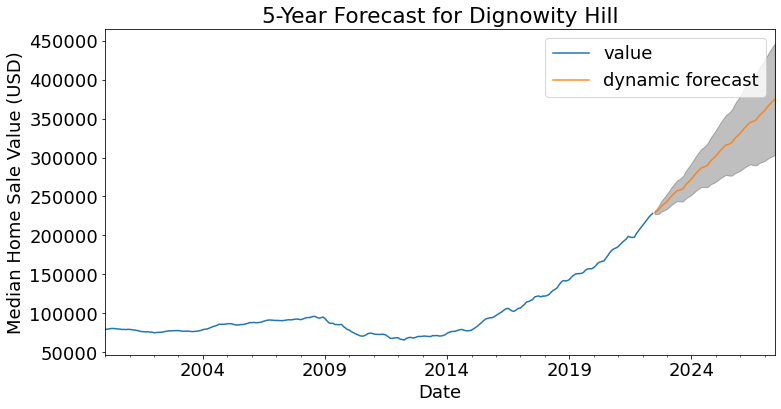

{'forecast': 374878.0, 'minimum': 303162.0, 'maximum': 446593.0}

In [390]:
dynamic_forecast(dig_hill, output_dig_hill, neighborhood='Dignowity Hill', years=5, save_fig=True)

Once again, we see negative correlation at month 3, this should be expected with all of the rest of our zipcode plots.  The residuals do have a few tail outliers, but are distributed normally.  The confidence interval of our forecasts is smaller than what we saw in the Arena District, and the RMSE is lower at $1446.  

#### Gardendale / Brady Gardens

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7256      0.049     14.850      0.000       0.630       0.821
ma.L1          0.0109      0.070      0.156      0.876      -0.126       0.147
ma.S.L12      -0.6518      0.043    -15.195      0.000      -0.736      -0.568
sigma2      3.649e+05    3.2e+04     11.394      0.000    3.02e+05    4.28e+05


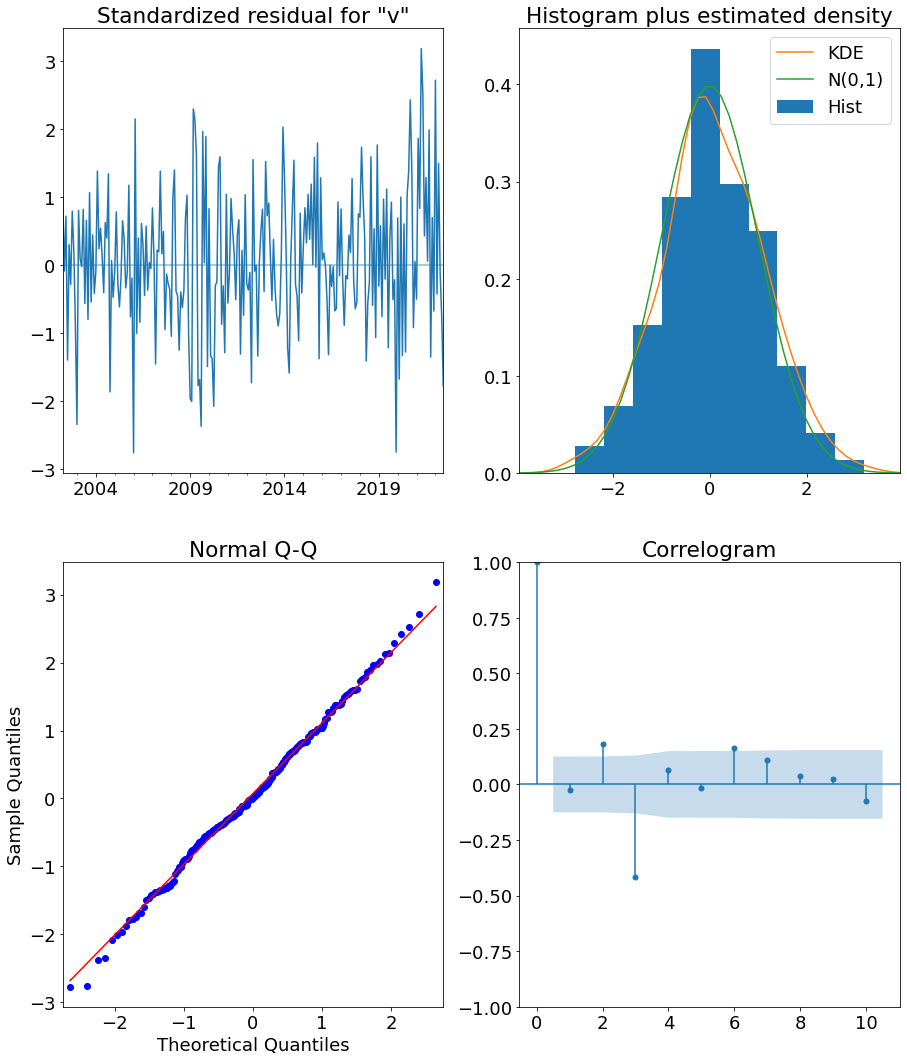

In [316]:
b_gardens = zip_df[2]
output_b_gardens = sarimax(b_gardens, order=(1, 1, 1), seasonal_order=(0, 1, 1, 12))

The RMSE of our forecasts is 856.1


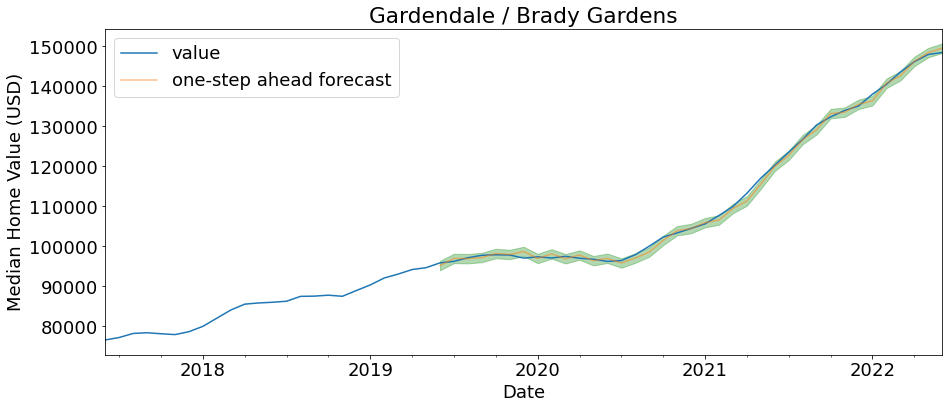

In [317]:
ose_forecast(b_gardens, output_b_gardens, neighborhood='Gardendale / Brady Gardens')

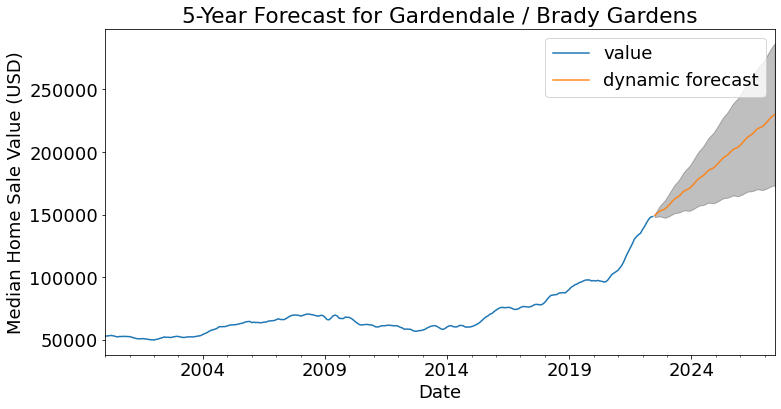

{'forecast': 229884.0, 'minimum': 173058.0, 'maximum': 286710.0}

In [318]:
dynamic_forecast(b_gardens, output_b_gardens, neighborhood='Gardendale / Brady Gardens', years=5)

Once again, we achieved a lower RMSE for Gardendale area at $856.  The residuals are normally distributed without any significant outliers.  

#### Kingsbury

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6708      0.102      6.553      0.000       0.470       0.871
ma.L1          0.0476      0.137      0.348      0.728      -0.221       0.316
ar.S.L12      -0.5986      0.112     -5.325      0.000      -0.819      -0.378
ma.S.L12      -0.0105      0.061     -0.171      0.864      -0.131       0.110
sigma2      2.151e+07   2.25e-09   9.56e+15      0.000    2.15e+07    2.15e+07


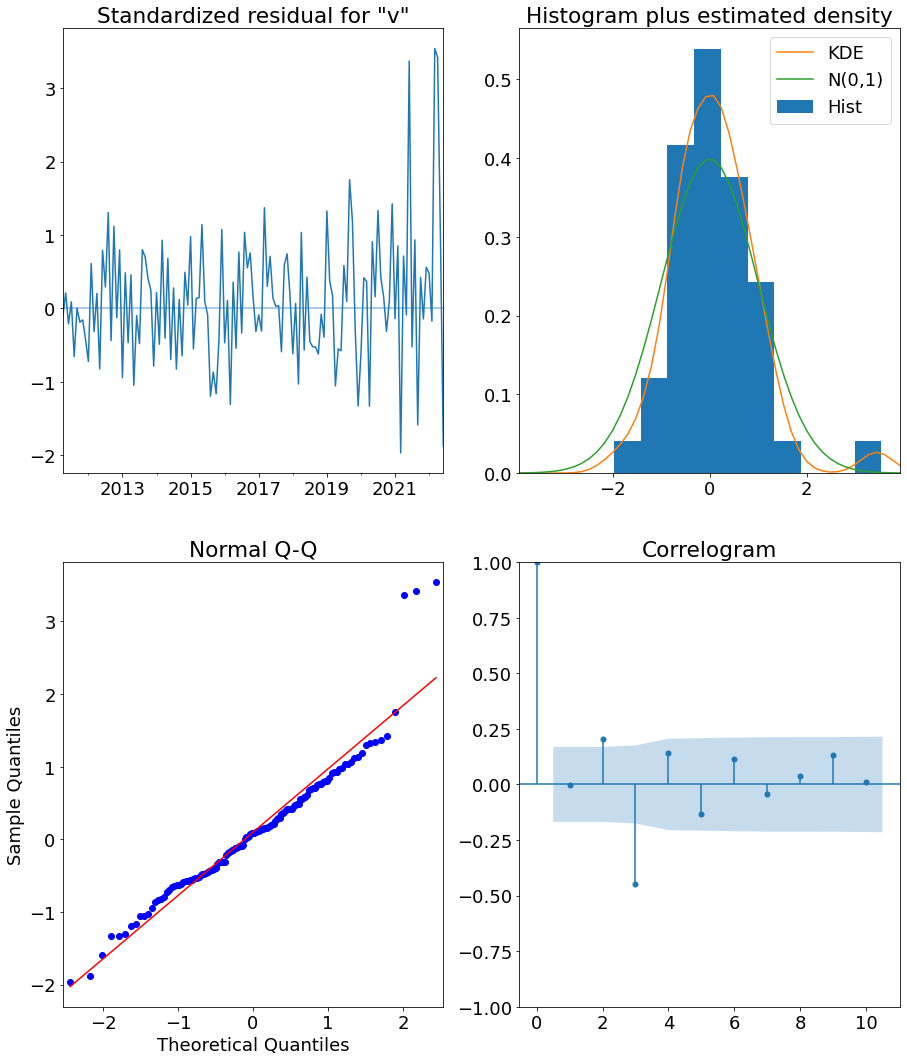

In [319]:
kingsbury = zip_df[3]
output_kingsbury = sarimax(kingsbury, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))

The RMSE of our forecasts is 6104.66


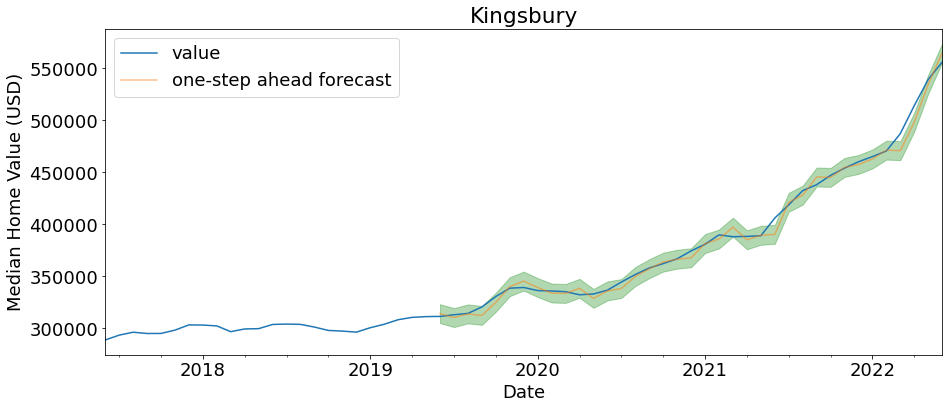

In [320]:
ose_forecast(kingsbury, output_kingsbury, neighborhood='Kingsbury')

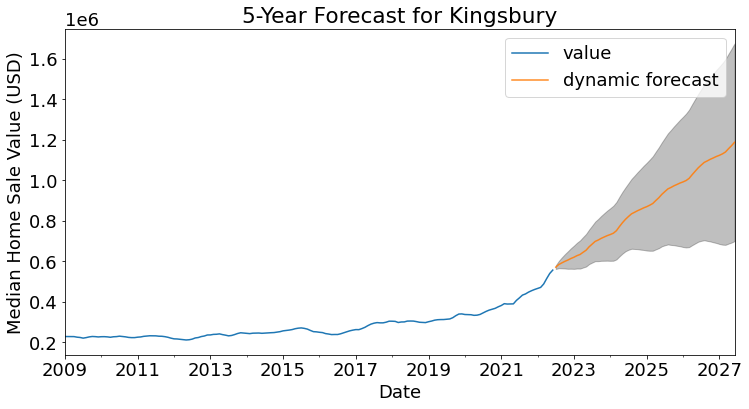

{'forecast': 1187524.0, 'minimum': 698989.0, 'maximum': 1676059.0}

In [321]:
dynamic_forecast(kingsbury, output_kingsbury, neighborhood='Kingsbury', years=5)

The RMSE of our predictions is $6,104 which is higher than our other zipcodes but the price of the homes are much higher in Kingsbury than the other areas.  However, Kingsbury has some pretty significant outliers on the high end which is skewing the distribution of the residuals.

#### Medina

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6341      0.093      6.837      0.000       0.452       0.816
ma.L1          0.0627      0.119      0.527      0.599      -0.171       0.296
ma.S.L12      -0.2064      0.039     -5.249      0.000      -0.284      -0.129
sigma2      2.866e+06   3.32e+05      8.626      0.000    2.21e+06    3.52e+06


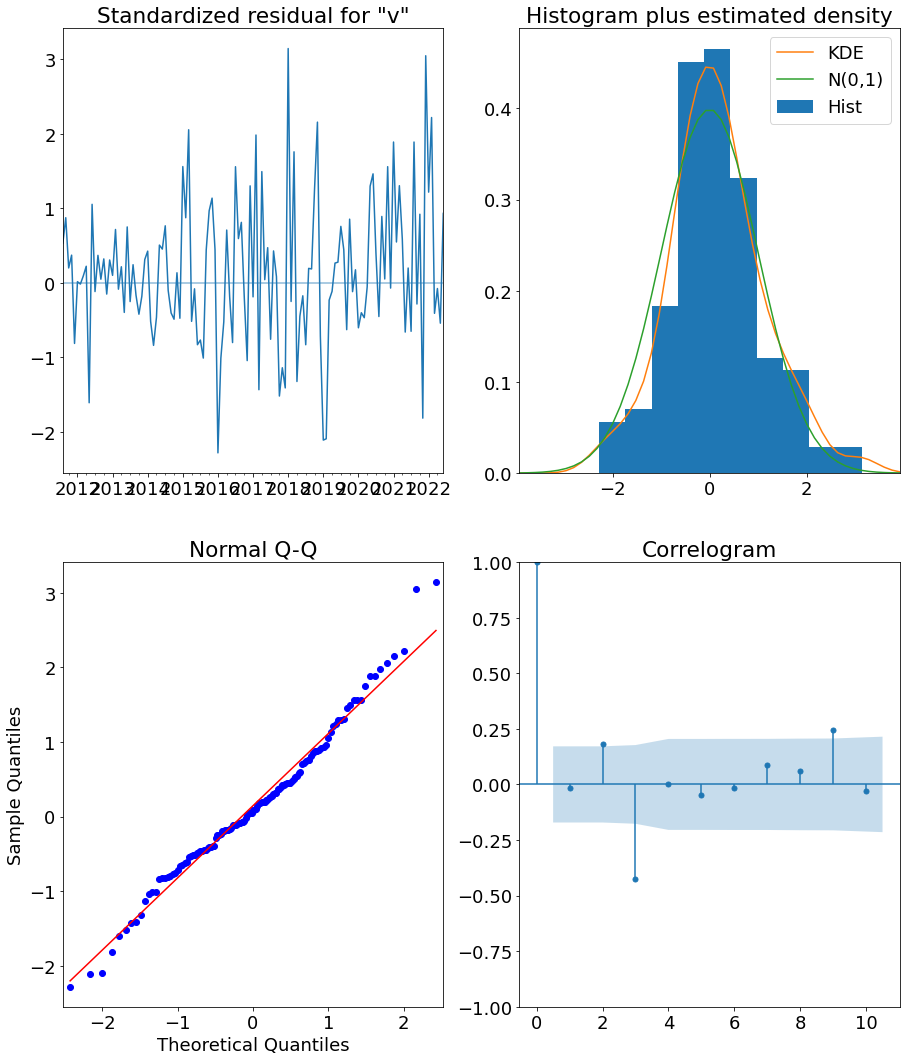

In [322]:
medina = zip_df[4]
output_medina = sarimax(medina, order=(1, 1, 1), seasonal_order=(0, 1, 1, 12))

The RMSE of our forecasts is 1798.26


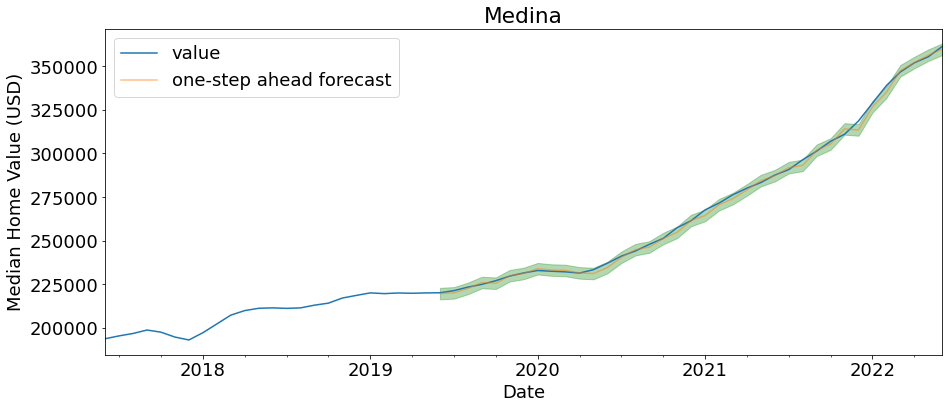

In [323]:
ose_forecast(medina, output_medina, neighborhood='Medina')

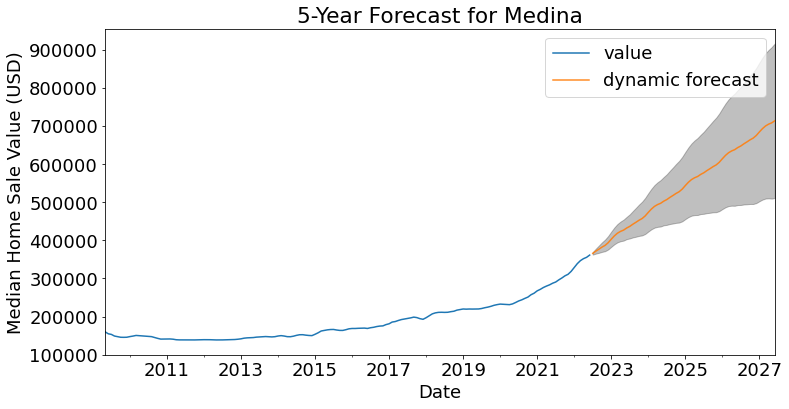

{'forecast': 713491.0, 'minimum': 510850.0, 'maximum': 916132.0}

In [324]:
dynamic_forecast(medina, output_medina, neighborhood='Medina', years=5)

The RMSE of our predictions for Medina is $1,798, which is similar to some of our other zipcodes we have already seen, and we can see the presence of a few outliers in the Q-Q plot.

#### Denver Heights / Highland Park

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6916      0.040     17.311      0.000       0.613       0.770
ma.L1          0.1066      0.067      1.597      0.110      -0.024       0.237
ma.S.L12      -0.5716      0.034    -16.696      0.000      -0.639      -0.504
sigma2       4.35e+05   3.03e+04     14.333      0.000    3.76e+05    4.94e+05


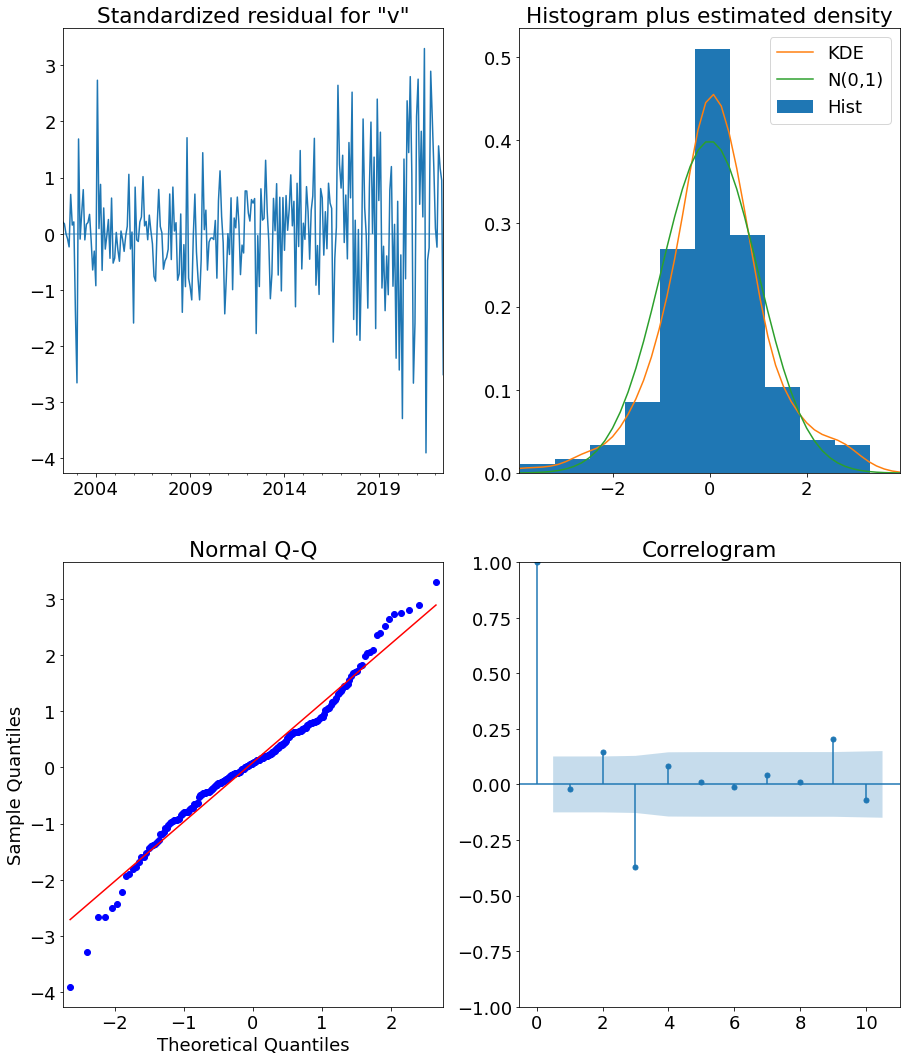

In [325]:
highland_park = zip_df[5]
output_highland_park = sarimax(highland_park, order=(1, 1, 1), seasonal_order=(0, 1, 1, 12))

The RMSE of our forecasts is 1198.29


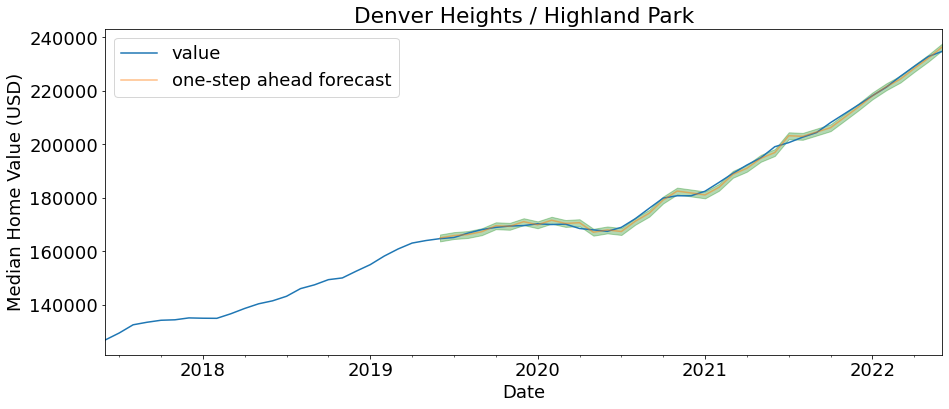

In [326]:
ose_forecast(highland_park, output_highland_park, neighborhood='Denver Heights / Highland Park')

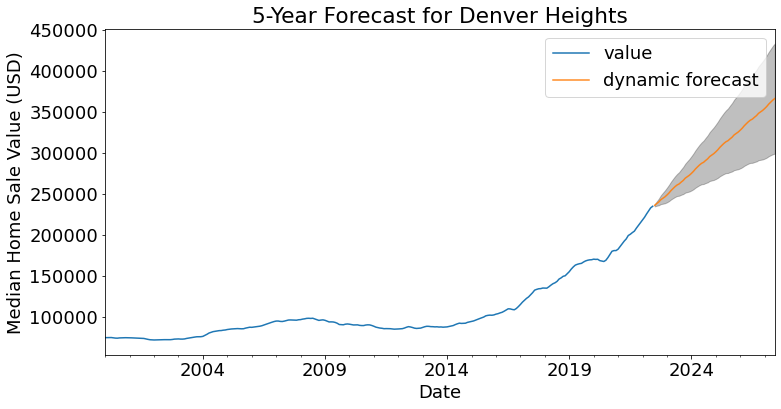

{'forecast': 366017.0, 'minimum': 298896.0, 'maximum': 433138.0}

In [392]:
dynamic_forecast(highland_park, output_highland_park, neighborhood='Denver Heights', years=5, save_fig=True)

Once again, residuals are mostly normal with outliers on the tails.  The RMSE of our predictions is $1198. The confidence interval appears to be smaller than several others we have seen.

#### Inner Westside

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6936      0.065     10.635      0.000       0.566       0.821
ma.L1          0.0103      0.096      0.108      0.914      -0.177       0.198
ar.S.L12      -0.4601      0.063     -7.347      0.000      -0.583      -0.337
ma.S.L12      -0.1084      0.034     -3.156      0.002      -0.176      -0.041
sigma2      4.368e+05   3.72e+04     11.730      0.000    3.64e+05     5.1e+05


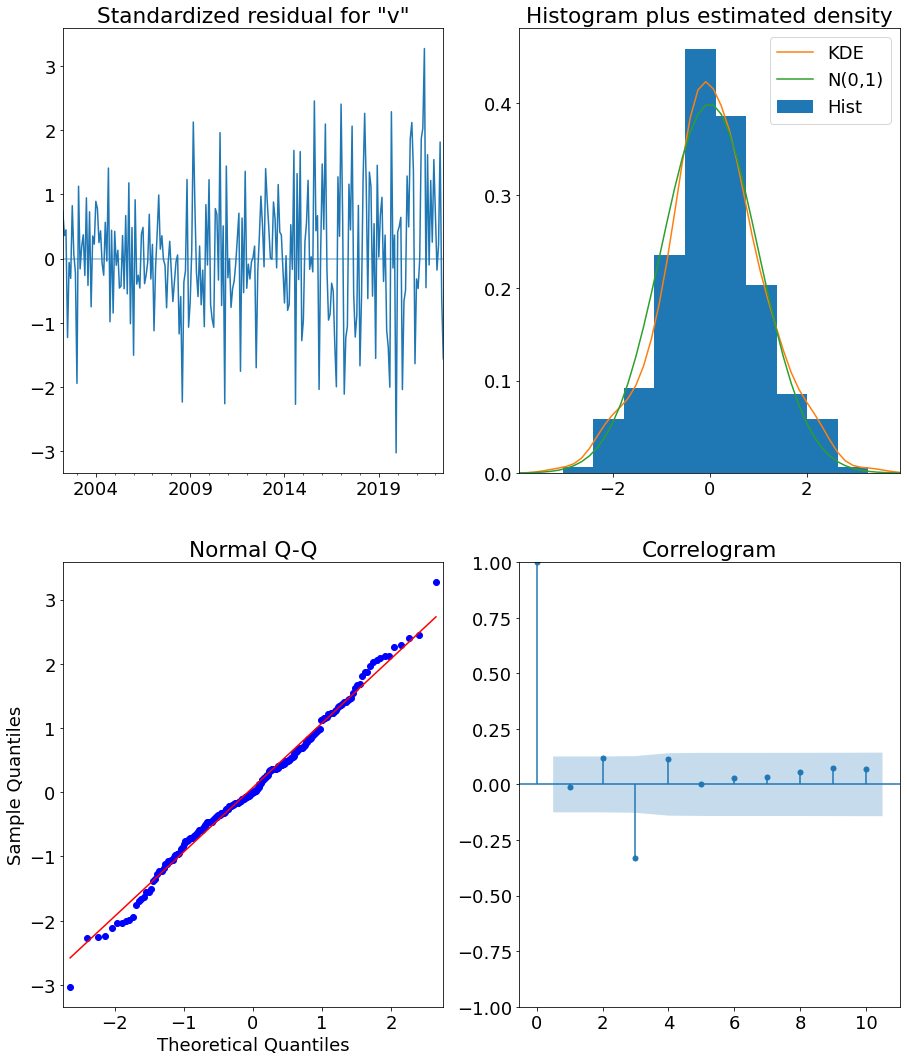

In [328]:
inner_westside = zip_df[6]
output_inner_westside = sarimax(inner_westside, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))

The RMSE of our forecasts is 933.67


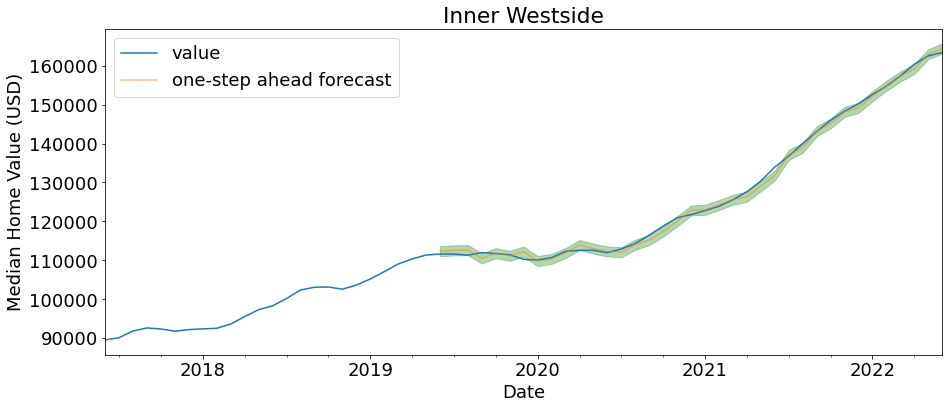

In [329]:
ose_forecast(inner_westside, output_inner_westside, neighborhood='Inner Westside')

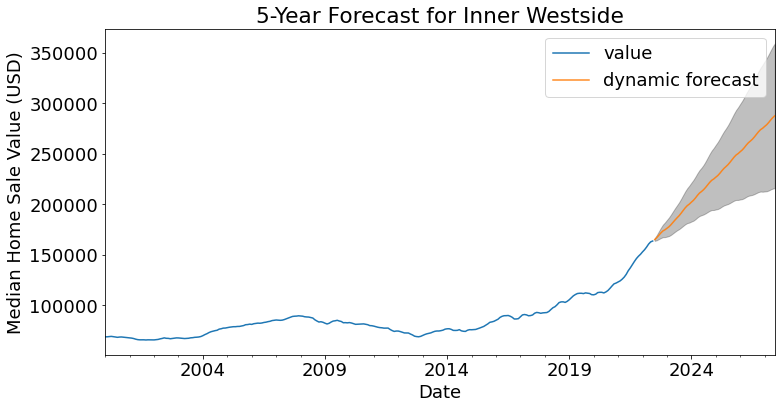

{'forecast': 287589.0, 'minimum': 215798.0, 'maximum': 359380.0}

In [393]:
dynamic_forecast(inner_westside, output_inner_westside, neighborhood='Inner Westside', years=5, save_fig=True)

The residuals are normal for the inner westside zipcode, and we have an RMSE of $933.  The price point for this neighborhood is is around 150k right now, with the forecast expected to increase to 287k in 5 years.  

#### Fisher

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8604      0.033     25.747      0.000       0.795       0.926
ma.L1          0.1090      0.075      1.456      0.145      -0.038       0.256
ar.S.L12      -0.6351      0.085     -7.473      0.000      -0.802      -0.469
ma.S.L12       0.0176      0.046      0.385      0.700      -0.072       0.108
sigma2      2.488e+06   2.55e+05      9.751      0.000    1.99e+06    2.99e+06


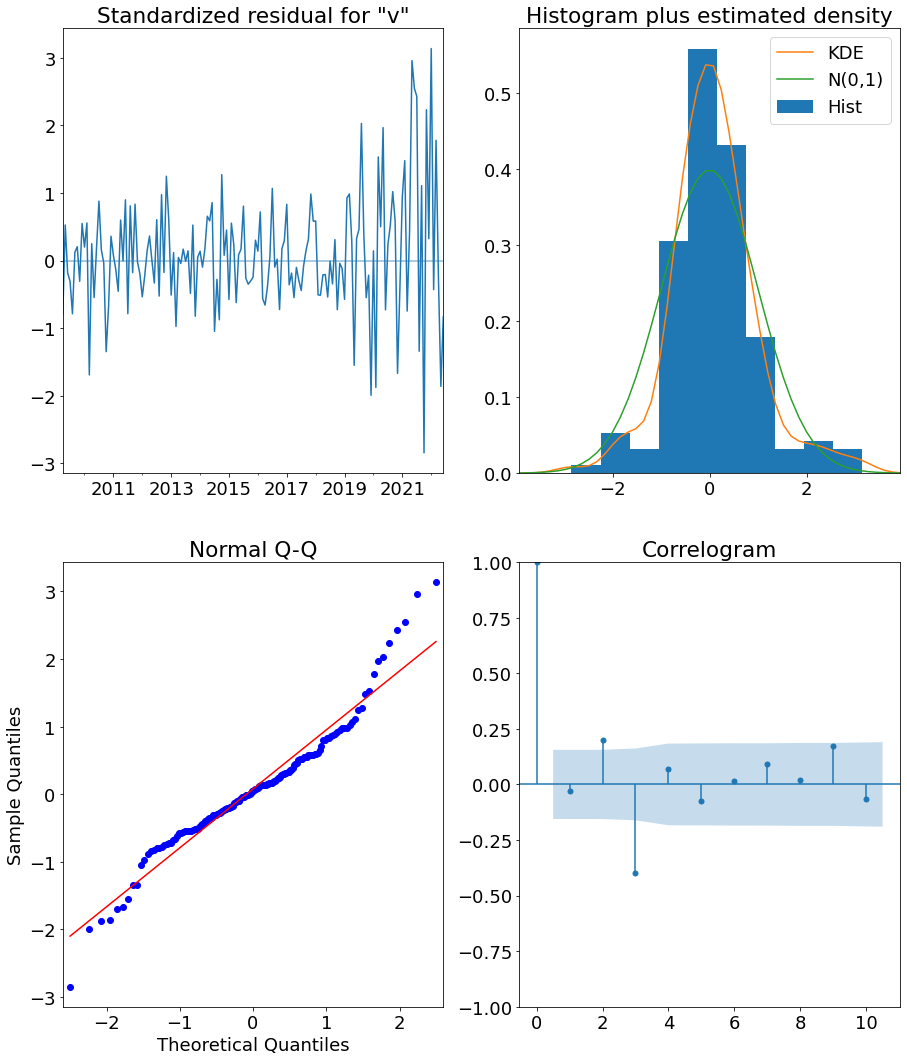

In [331]:
fisher = zip_df[7]
output_fisher = sarimax(fisher, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))

The RMSE of our forecasts is 2358.43


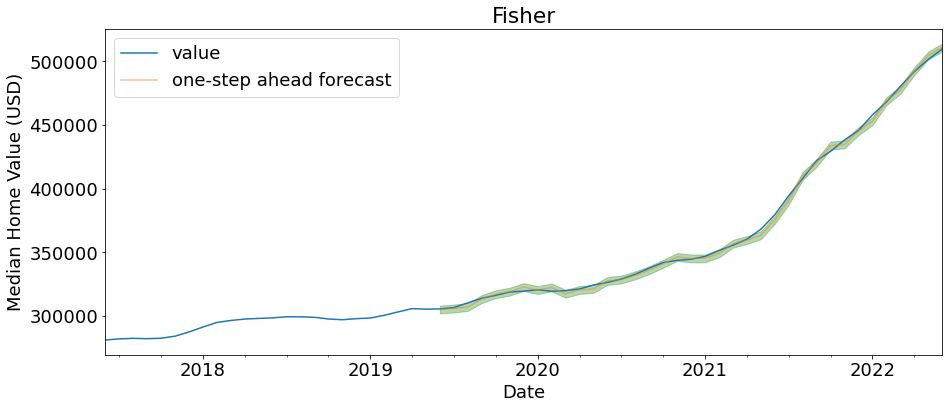

In [332]:
ose_forecast(fisher, output_fisher, neighborhood='Fisher')

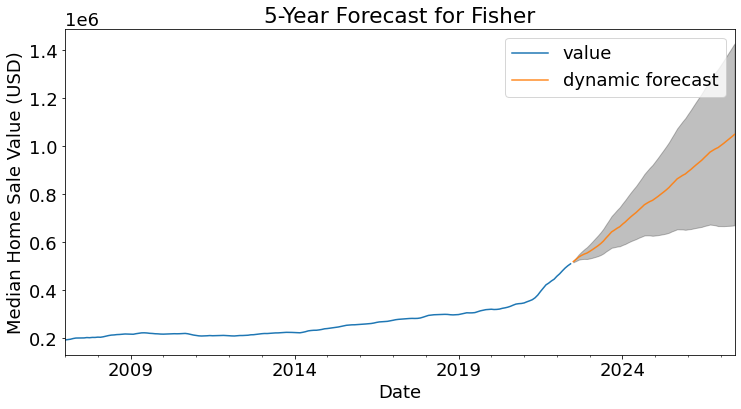

{'forecast': 1048416.0, 'minimum': 669827.0, 'maximum': 1427004.0}

In [333]:
dynamic_forecast(fisher, output_fisher, neighborhood='Fisher', years=5)

We can see the presence of heavy outliers.  This is an area that is relatively new near Canyon Lake.  There are many custom luxury homes in the area due to its location near the lake.  The RMSE of our predictions is $2358. The confidence interval for our forecasts is very large, which means there is a large amount of uncertainty.  The median home value has shot up 150k in the past 2 years due to it becoming a highly desirable area for retirees.  While the gains could be huge in this area, it is not likely to be the safest investment based on the very steep increase over the past 2 years which could taper off.

#### Canyon Lake

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9157      0.061     14.986      0.000       0.796       1.035
ma.L1          0.1537      0.137      1.121      0.262      -0.115       0.422
ar.S.L12      -0.7337      0.125     -5.855      0.000      -0.979      -0.488
ma.S.L12      -0.0034      0.067     -0.052      0.959      -0.134       0.127
sigma2      2.152e+06   3.35e+05      6.429      0.000     1.5e+06    2.81e+06


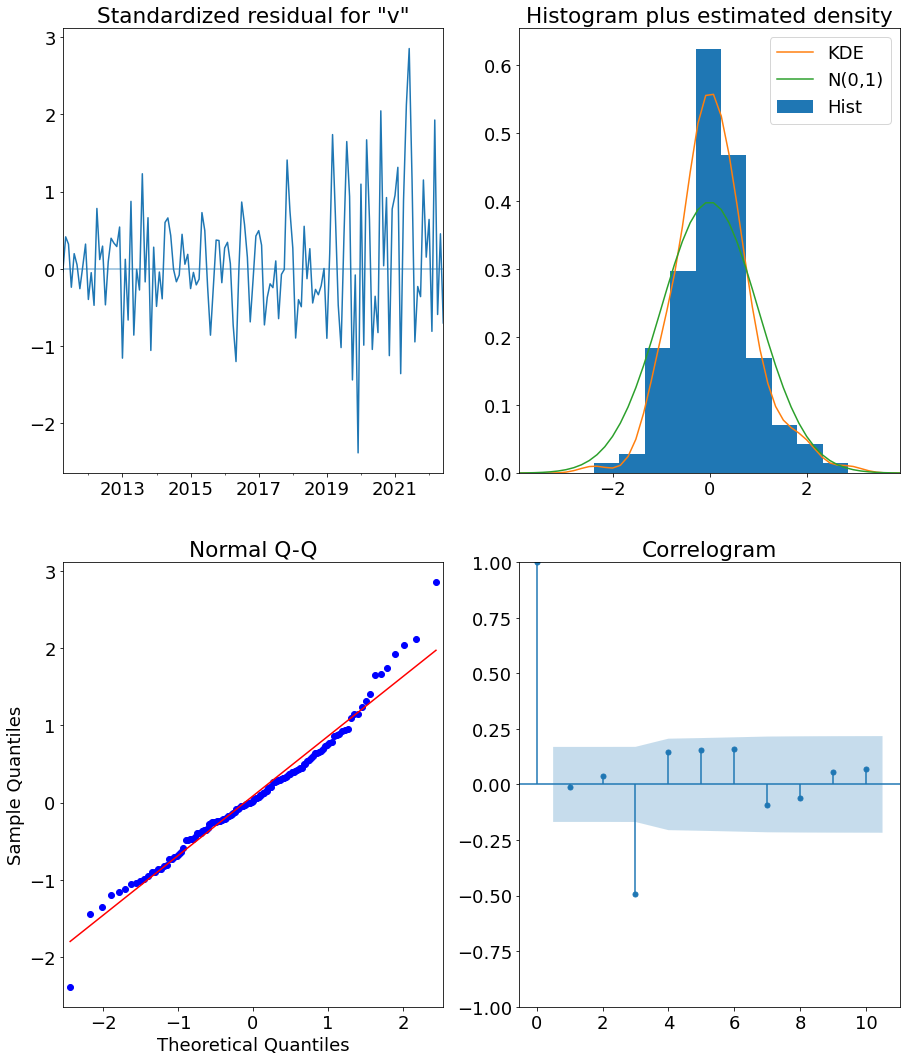

In [334]:
canyon_lake = zip_df[8]
output_canyon_lake = sarimax(canyon_lake, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))

The RMSE of our forecasts is 1773.47


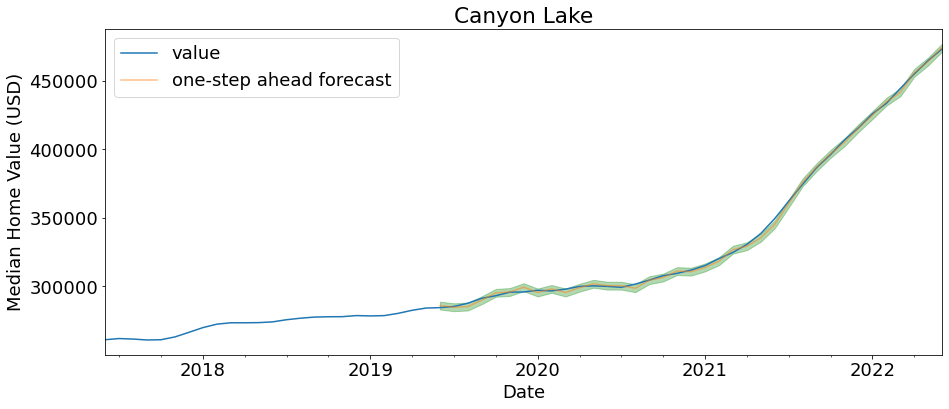

In [335]:
ose_forecast(canyon_lake, output_canyon_lake, neighborhood='Canyon Lake')

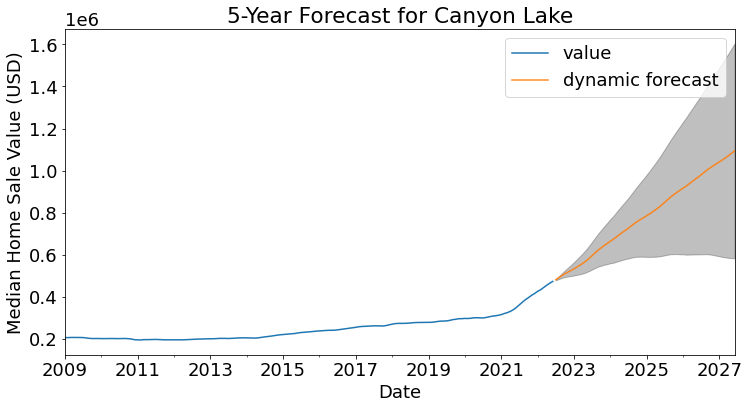

{'forecast': 1093740.0, 'minimum': 582966.0, 'maximum': 1604515.0}

In [336]:
dynamic_forecast(canyon_lake, output_canyon_lake, neighborhood='Canyon Lake', years=5)

We can see the same thing happening in Canyon Lake, the median value of homes has shot up 150k in the past year, and Canyon Lake also has a high entry point into the market right now.  Due to the high increases in the past year, the confidence interval is very large for Canyon Lake and this would be a riskier investment.  There is a spread of 1 million dollars in our confidence interval!

#### Eastside

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6822      0.051     13.399      0.000       0.582       0.782
ma.L1          0.0998      0.078      1.284      0.199      -0.053       0.252
ar.S.L12      -0.5868      0.054    -10.903      0.000      -0.692      -0.481
ma.S.L12      -0.1070      0.034     -3.151      0.002      -0.174      -0.040
sigma2      3.593e+05   2.94e+04     12.241      0.000    3.02e+05    4.17e+05


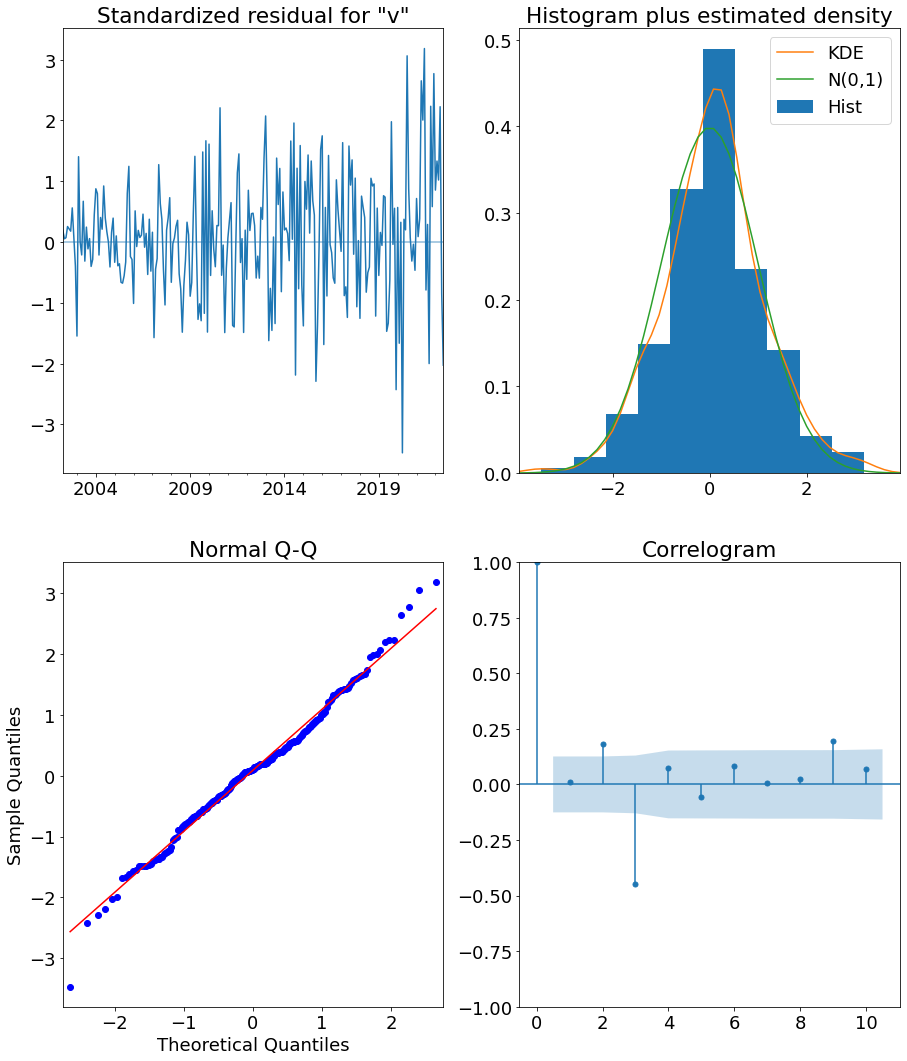

In [337]:
eastside = zip_df[9]
output_eastside = sarimax(eastside, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))

The RMSE of our forecasts is 951.41


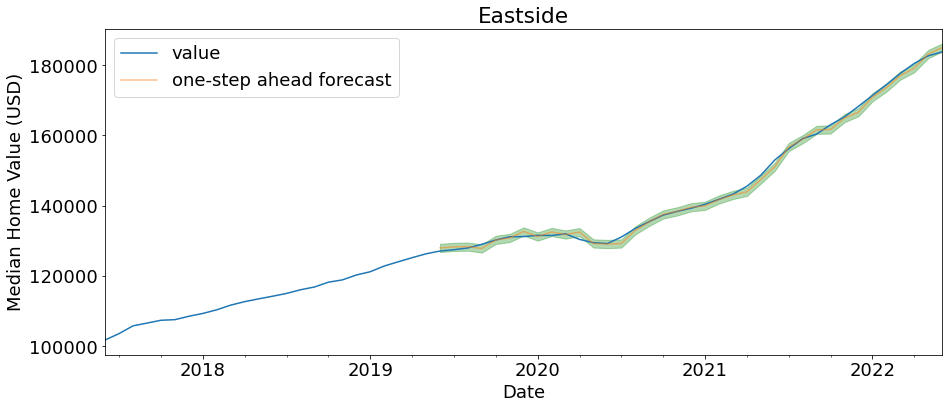

In [338]:
ose_forecast(eastside, output_eastside, neighborhood='Eastside')

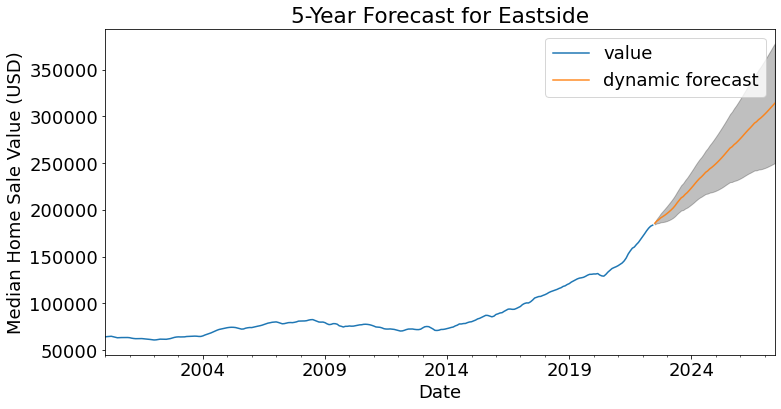

{'forecast': 313952.0, 'minimum': 249978.0, 'maximum': 377926.0}

In [394]:
dynamic_forecast(eastside, output_eastside, neighborhood='Eastside', years=5, save_fig=True)

The RMSE of our predictions for the Eastside is $951, with a relatively small confidence interval for our forecasts.  The entry point into the neighborhood is low at around 180k, with our 5 year forecast predicting to increase to 313k.  The residuals are normal with some outliers on the tails.  

## Interpret Results

### Projections for 3 and 5 year ROI

I am now going to make a dataframe that will contain our projected metrics based upon our sarimax model forecasting.

In [340]:
def projections(ts, zipcodes, years):
    '''
    Calculate projections for each zip code.
        - Current Value
        - ROI (return on investment)
        
    Input:
        ts : time series data.
        zipcodes : list of zip codes to iterate through.
        years : n-number of years to forecast.
        
    Output:
        Returns dataframe with:
        - zip code
        - current value
        - predicted value
        - predicted ROI

    '''
    
    # Define steps for forecasting
    steps = years*12
    
    # Create list to append projection metrics
    projections = []
    
    # Iterate through time series of each zip code
    for zipcode in zipcodes:
        
        # Time series of zip code
        zip_ts = ts[ts['RegionName'] == zipcode]
        to_drop = ['RegionName']
        zip_ts = zip_ts.drop(to_drop, axis=1)
        
        # Plug the optimal parameter values into a new SARIMAX model
        # I used the values that were the most frequent for out top 10 zipcodes
        SARIMAX = sm.tsa.statespace.SARIMAX(zip_ts,
                                            order=(1, 1, 1),
                                            seasonal_order=(1, 1, 1, 12),
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

        # Fit the model and print results
        output = SARIMAX.fit()
    
        # Get forecast and confidence interval for steps ahead in future
        forecast = output.get_forecast(steps=steps, dynamic=True)
        conf_int = forecast.conf_int()

        # Show prediction for end of step-period
        pred_mean = forecast.predicted_mean[-1]
        pred_mean_min = conf_int.iloc[-1,0]
        pred_mean_max = conf_int.iloc[-1,1]
        
        # Last value of the time series - this will be used to calculate projected ROI
        current_value = zip_ts['value'][-1]
        
        # ROI (Return on Investment) as Percentage
        ROI = ((pred_mean-current_value)/current_value *100)
        ROI_min = ((pred_mean_min-current_value)/current_value *100)
        ROI_max = ((pred_mean_max-current_value)/current_value *100)
        
        # Create DataFrame
        
        # Initiate empty dictionary
        predicted = {}
        
        # Columns for df
        predicted['zipcode'] = zipcode
        predicted['predicted_mean'] = pred_mean
        predicted['predicted_mean_min'] = pred_mean_min
        predicted['predicted_mean_max'] = pred_mean_max
        predicted['current_value'] = current_value
        predicted['ROI'] = ROI
        predicted['ROI_min'] = ROI_min
        predicted['ROI_max'] = ROI_max

        # Append to list
        projections.append(predicted)
        
        # Return in DataFrame format     
    return pd.DataFrame.from_dict(projections)

In [377]:
# Get 3 year projections for top 10 zip codes
three_year_projections = projections(model_df, zip_list, years=3)
three_year_projections

zipcode  predicted_mean  predicted_mean_min  predicted_mean_max  \
0    78203   339839.659781       283808.209827        3.958711e+05   
1    78202   316210.201653       277737.856239        3.546825e+05   
2    78207   217501.235532       180366.222136        2.546362e+05   
3    78638   930184.768415       673410.443085        1.186959e+06   
4    78055   569344.073180       465645.706910        6.730424e+05   
5    78210   337287.142431       295798.772725        3.787755e+05   
6    78237   237227.359318       199425.668841        2.750290e+05   
7    78623   827218.413706       638932.679286        1.015504e+06   
8    78133   837285.818728       594395.248170        1.080176e+06   
9    78220   260936.102386       226854.292676        2.950179e+05   

   current_value        ROI    ROI_min     ROI_max  
0       241568.0  40.680744  17.485847   63.875642  
1       228219.0  38.555599  21.697955   55.413242  
2       148461.0  46.503954  21.490642   71.517266  
3       555727.0  67.381604  21.176485  113.586724  
4       361314.0  57.575979  28.875634   86.276325  
5       234712.0  43.702556  26.026267   61.378844  
6       163415.0  45.168656  22.036330   68.300982  
7       509544.0  62.344844  25.393034   99.296655  
8       473175.0  76.950561  25.618481  128.282642  
9       183720.0  42.029231  23.478278   60.580183

In [342]:
# Get 5 year projections for top 10 zip codes
five_year_projections = projections(model_df, zip_list, years=5)
five_year_projections

zipcode  predicted_mean  predicted_mean_min  predicted_mean_max  \
0    78203    4.056760e+05       301026.597381        5.103253e+05   
1    78202    3.748779e+05       303162.465320        4.465933e+05   
2    78207    2.647553e+05       195127.425476        3.343833e+05   
3    78638    1.187524e+06       698988.571529        1.676059e+06   
4    78055    7.087825e+05       507903.173453        9.096617e+05   
5    78210    4.061204e+05       327701.408459        4.845394e+05   
6    78237    2.875893e+05       215798.425616        3.593803e+05   
7    78623    1.048416e+06       669826.723065        1.427004e+06   
8    78133    1.093740e+06       582965.843622        1.604515e+06   
9    78220    3.139520e+05       249978.261510        3.779257e+05   

   current_value         ROI    ROI_min     ROI_max  
0       241568.0   67.934482  24.613607  111.255358  
1       228219.0   64.262353  32.838399   95.686306  
2       148461.0   78.333262  31.433458  125.233066  
3       555727.0  113.688333  25.779127  201.597538  
4       361314.0   96.168003  40.571130  151.764876  
5       234712.0   73.029237  39.618515  106.439959  
6       163415.0   75.987118  32.055457  119.918779  
7       509544.0  105.755657  31.456110  180.055204  
8       473175.0  131.149225  23.203010  239.095440  
9       183720.0   70.886124  36.064806  105.707443

In [343]:
# Sort values based on ROI for 3 year projections
three_year_projections.sort_values('ROI')

zipcode  predicted_mean  predicted_mean_min  predicted_mean_max  \
1    78202   316210.201653       277737.856239        3.546825e+05   
0    78203   339839.659781       283808.209827        3.958711e+05   
9    78220   260936.102386       226854.292676        2.950179e+05   
5    78210   337287.142431       295798.772725        3.787755e+05   
6    78237   237227.359318       199425.668841        2.750290e+05   
2    78207   217501.235532       180366.222136        2.546362e+05   
4    78055   569344.073180       465645.706910        6.730424e+05   
7    78623   827218.413706       638932.679286        1.015504e+06   
3    78638   930184.768415       673410.443085        1.186959e+06   
8    78133   837285.818728       594395.248170        1.080176e+06   

   current_value        ROI    ROI_min     ROI_max  
1       228219.0  38.555599  21.697955   55.413242  
0       241568.0  40.680744  17.485847   63.875642  
9       183720.0  42.029231  23.478278   60.580183  
5       234712.0  43.702556  26.026267   61.378844  
6       163415.0  45.168656  22.036330   68.300982  
2       148461.0  46.503954  21.490642   71.517266  
4       361314.0  57.575979  28.875634   86.276325  
7       509544.0  62.344844  25.393034   99.296655  
3       555727.0  67.381604  21.176485  113.586724  
8       473175.0  76.950561  25.618481  128.282642

In [344]:
# Sort values based on ROI for 5 year projections
five_year_projections.sort_values('ROI')

zipcode  predicted_mean  predicted_mean_min  predicted_mean_max  \
1    78202    3.748779e+05       303162.465320        4.465933e+05   
0    78203    4.056760e+05       301026.597381        5.103253e+05   
9    78220    3.139520e+05       249978.261510        3.779257e+05   
5    78210    4.061204e+05       327701.408459        4.845394e+05   
6    78237    2.875893e+05       215798.425616        3.593803e+05   
2    78207    2.647553e+05       195127.425476        3.343833e+05   
4    78055    7.087825e+05       507903.173453        9.096617e+05   
7    78623    1.048416e+06       669826.723065        1.427004e+06   
3    78638    1.187524e+06       698988.571529        1.676059e+06   
8    78133    1.093740e+06       582965.843622        1.604515e+06   

   current_value         ROI    ROI_min     ROI_max  
1       228219.0   64.262353  32.838399   95.686306  
0       241568.0   67.934482  24.613607  111.255358  
9       183720.0   70.886124  36.064806  105.707443  
5       234712.0   73.029237  39.618515  106.439959  
6       163415.0   75.987118  32.055457  119.918779  
2       148461.0   78.333262  31.433458  125.233066  
4       361314.0   96.168003  40.571130  151.764876  
7       509544.0  105.755657  31.456110  180.055204  
3       555727.0  113.688333  25.779127  201.597538  
8       473175.0  131.149225  23.203010  239.095440

Our projections for 3 years and 5 years have the same ranking order of each zip code which is great. In order to aid visualization, I am going to write a function to produce a bar plot with predicted ROI and errors associated with each zip code.

### Barplots of ROI Projections and Errors

In [382]:
# Barplot for x years projection with 95% confidence intervals
def projection_barplot(df, years=3, save_fig=False):
    # Plot Predicted Mean Home Sale Values #

    # Get errors; (pred mean - lower bound of conf interval)
    errors = df['ROI'] - df['ROI_min']
    df['errors'] = errors
    
    # Zipcode x-labels
    variables = list(df.zipcode.values)
    df['variables'] = variables

    # Define figure, axes, and plot
    fig, ax = plt.subplots(figsize=(16, 6))
    
    # Plot barplot of ROI with errors
    plt.rcParams.update({'font.size': 18})
    df.plot(x='variables', 
            y='ROI', 
            kind='bar',
            ax=ax, 
            color='none', 
            ecolor='black',
            capsize=10,
            yerr='errors', 
            legend=False)
    #Labels
    ax.set_xlabel('Zip Code')
    ax.set_ylabel('ROI')
    plt.title(f'{years} Year ROI w/ 95% Confidence Intervals')

    # Predicted ROI
    ax.scatter(x=pd.np.arange(df.shape[0]),
               marker='s', 
               s=40, 
               y=df['ROI'], 
               color='black')
    
    # Line to help visualize on the y-axis
    ax.axhline(y=50, linestyle='--', color='red', linewidth=1.5)
    
    if save_fig:
        plt.savefig(f'./images/barplot_{years}.jpeg')
    
    # Rotate zip code labels 45 degrees
    plt.xticks(rotation=45)
    plt.show();

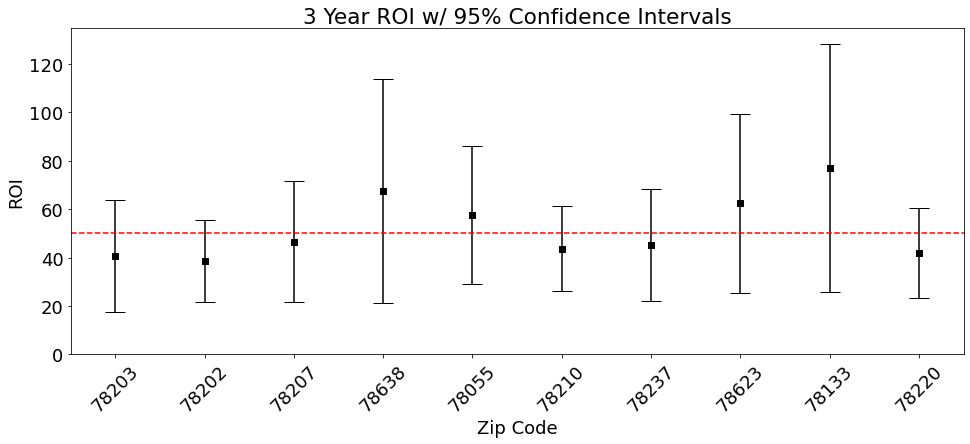

In [346]:
# 3 year ROI projections
projection_barplot(three_year_projections, years=3)

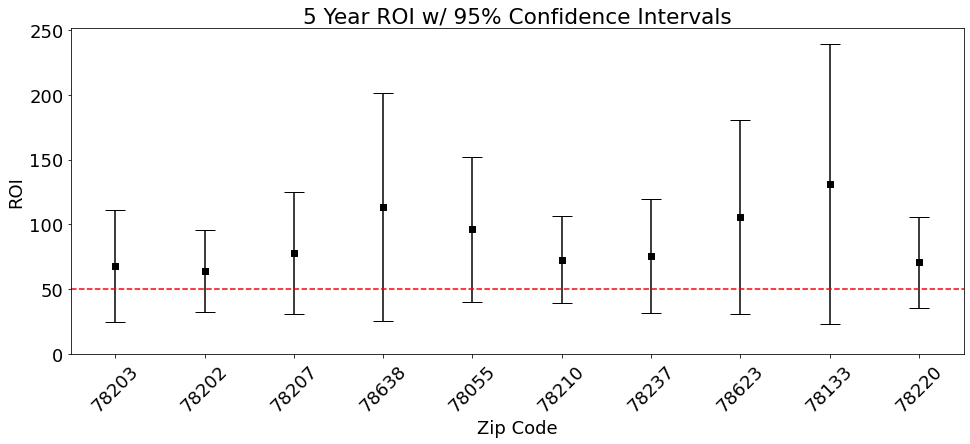

In [347]:
# 5 year ROI projections
projection_barplot(five_year_projections, years=5)

Since my client very concerned with low risk investments, I am going to select the top 5 zip codes from this list with the smallest confidence intervals.  This will remove those zip codes that have large variability and more fluctuation in the market vales.  These zip codes also happen to be the ones with the lowest ROI, but it appears it is hard to go wrong with any zip code in this metro area right now with it's massive growth with no end in sight.  

### Top 5 Zip Codes

In [379]:
# Top 5 zip codes
top_zip_projections = three_year_projections.sort_values('ROI')[0:5].sort_values('ROI', ascending=False)
top_zip_projections

zipcode  predicted_mean  predicted_mean_min  predicted_mean_max  \
6    78237   237227.359318       199425.668841       275029.049795   
5    78210   337287.142431       295798.772725       378775.512136   
9    78220   260936.102386       226854.292676       295017.912095   
0    78203   339839.659781       283808.209827       395871.109736   
1    78202   316210.201653       277737.856239       354682.547066   

   current_value        ROI    ROI_min    ROI_max  
6       163415.0  45.168656  22.036330  68.300982  
5       234712.0  43.702556  26.026267  61.378844  
9       183720.0  42.029231  23.478278  60.580183  
0       241568.0  40.680744  17.485847  63.875642  
1       228219.0  38.555599  21.697955  55.413242

Our top 5 zip codes are 78237 - Inner Westside, 78210 - Denver Heights, 78220 - Eastside, 78203 - Arena District, and 78202 - Dignowity Hill.  All 5 of these zip codes boast projected returns of 38% to 45%, and have great entry point prices ranging form 163k to 241k, far lower than the median value of the city.

78237 - Inner Westside, has the highest projected 3 year ROI and the lowest entry point at 163k, while 78202 - Dignowity Hill has the smallest variation and is therefore the safest investment. 

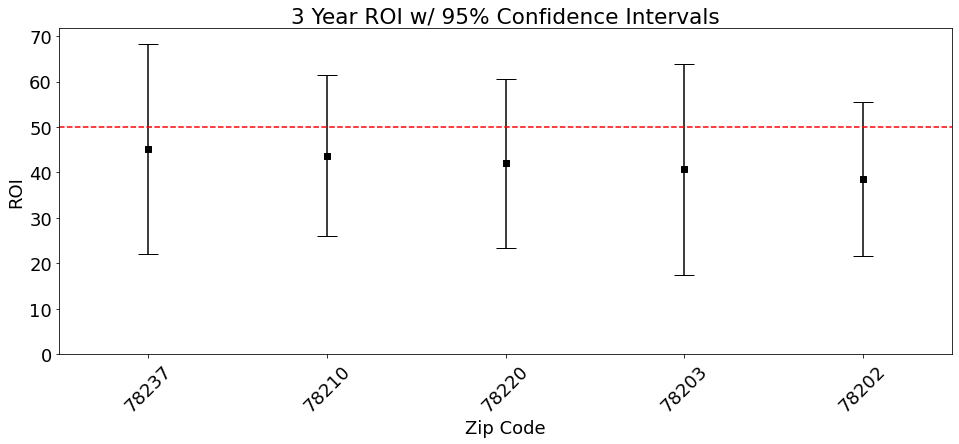

In [395]:
# Barplot of our 3 year projected ROI for top zip codes
projection_barplot(top_zip_projections, years=3, save_fig=True)

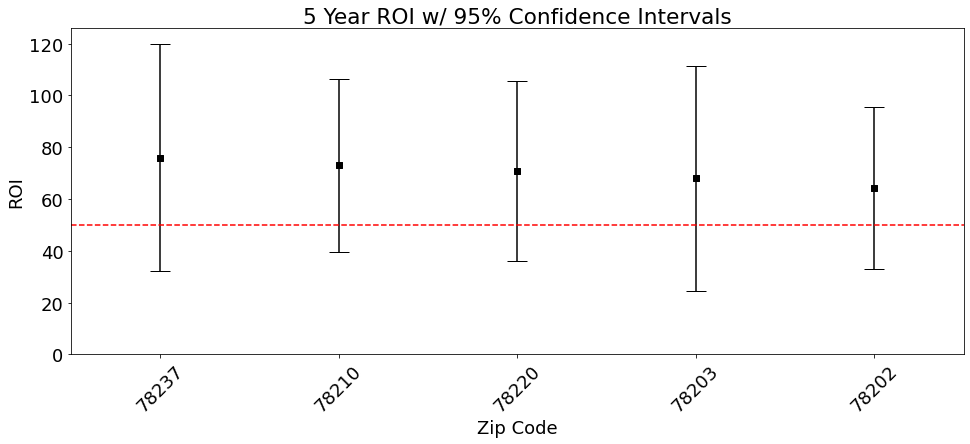

In [396]:
# Barplot of our 5 year projected ROI for our top zip codes
top_5year_projections = five_year_projections.sort_values('ROI')[0:5].sort_values('ROI', ascending=False)
top_5year_projections
projection_barplot(top_5year_projections, years=5, save_fig=True)

Our top zip codes have projected 5 year ROI of 64% to 76%! Now lets visualize the average sale prices or our top 5 zip codes over 22 years.

### Average Housing Prices of our Top 5 Zip Codes from 2000 - 2022

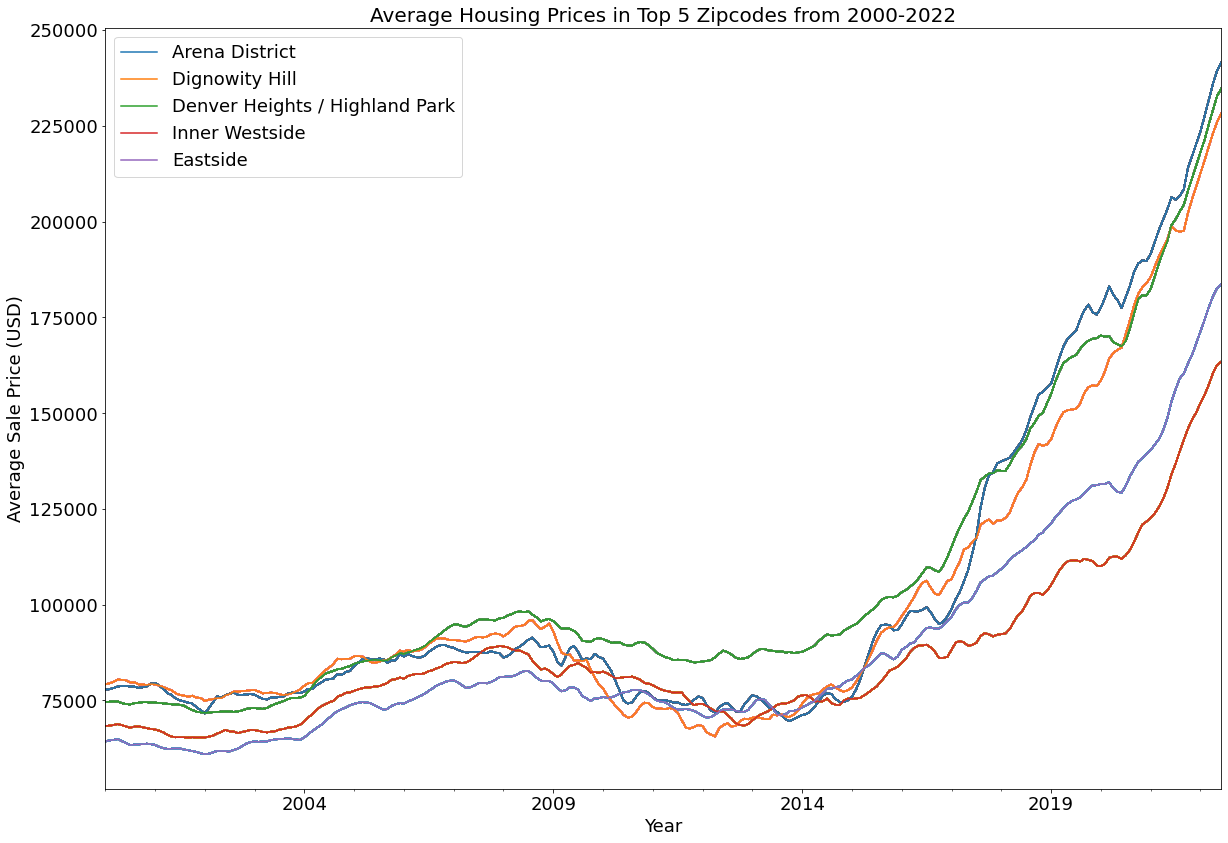

In [363]:
# Top 5 zip codes
top_5_zipcodes = [78203,78202,78210,78237,78220]

#plot the values grouped by zip code
plt.figure(figsize=(20,14))
for zipcode in model_df.RegionName.unique():
    for zipcode in top_5_zipcodes:
        model_df.loc[model_df['RegionName'] == zipcode].value.plot(label=zipcode)

plt.legend(labels=('Arena District','Dignowity Hill','Denver Heights / Highland Park',
                   'Inner Westside','Eastside'), loc='upper left')

plt.xlabel("Year", fontsize = 18)
plt.ylabel("Average Sale Price (USD)", fontsize=18)
plt.title('Average Housing Prices in Top 5 Zipcodes from 2000-2022', fontsize = 20)
# Save fig
plt.savefig('./images/top_5_over_time.jpeg')
plt.show();

We can see a similiar trend among all of our top 5 zip codes, although a bit more pronounced in the Arena District, Dignowity Hill, and Denver Heights.  This is likely due to the gentrification that has been taking place in these neighborhoods over the past several years and becoming desirable hotspots.  Unfortunately,  the crime rate is high in all of these neighborhoods and the schools all have below average ratings. It will likely take the schools several years to improve with the transition. 

## Conclusions

The top 5 zip codes ranked by highest return on investment (ROI) with the least amount of unpredictability and variation are:
* 78237: Inner Westside (lowest entry point)
* 78210: Denver Heights / Highland Park
* 78220: Eastside
* 78203: Arena District
* 78202: Dignowity Hill (safest investment - smallest variation)

These 5 zip codes boast projected returns on a 3 year investment ranging from 38% to 45%, and 5 year returns from 64% to 75%!  The entry price into these neighborhoods range from 163k to 241k, much lower than the average median price of the whole SA metro area at 348k.  

It should be noted that there is a caveat to these low prices, the schools are below average in every one of these zip codes and the rate of crime is high.  This is typical in big cities, and the schools typically improve as time goes on in neighborhoods with increasing home value.  If any of these factors are a concern, I recommend taking a look at the other zip codes that were in our top 10 ROI.  These other zip codes are in more desirable suburban areas that have good schools, but also come at a much higher entry point and more risk associated with the purchase. 

Some next steps in this project include added exogenous factors to our model, such as the median income of each zip code over time.  We could also do a facebook prophet model to compare the results of the sarimax model to.